# **Projet Max Drawdown**

Groupe :
- **AGRIOPOULOS Alexandre**
- **HADDAG Sid Ali**

Le but de ce projet est d'implémenter la mesure dite **Max Drawdown** sur des séries financières, puis d'en analyser la distribution statistique.

On commence par importer les packages nécessaires :

In [184]:
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Puis, il nous faut récupérer les données financières à analyser. Nous allons d'abord commencer par effectuer notre analyse sur l'historique complet du CAC40.

Pour ce faire, nous utilisons le package <code>yfinance</code>, qui va utiliser l'API Yahoo! Finance afin de télécharger les données qu'il nous faut.

Nous décidons de récupérer les valeurs du CAC40 quotidiennes, hebdomadaires et mensuelles à la fermeture, afin de comparer nos résultats pour différentes granularités.

In [185]:
cac40 = yf.Ticker("^FCHI")

cac40_1d = cac40.history(interval = "1d", period = "10y").Close.values 
cac40_1wk = cac40.history(interval = "1wk", period = "10y").Close.values 
cac40_1mo = cac40.history(interval = "1mo", period = "10y").Close.values 

On essaie d'abord d'observer la distribution initiale des prix sans prendre en compte la mesure "drawdown" par le biais des histogrammes suivants :

**CAC40 mensuel**

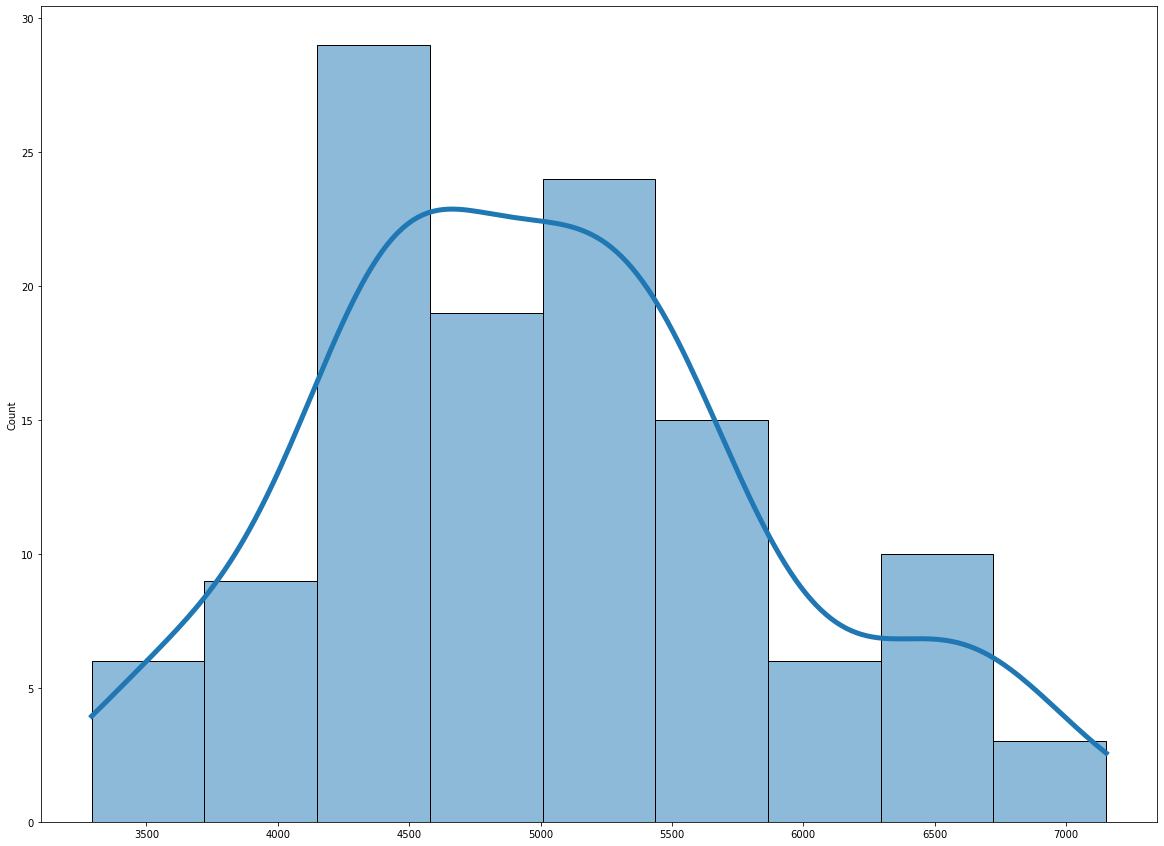

In [186]:
plt.figure(figsize=(20,15))
sns.histplot(data = cac40_1mo, kde=True, line_kws={"lw":5});

**CAC40 hebdomadaire**

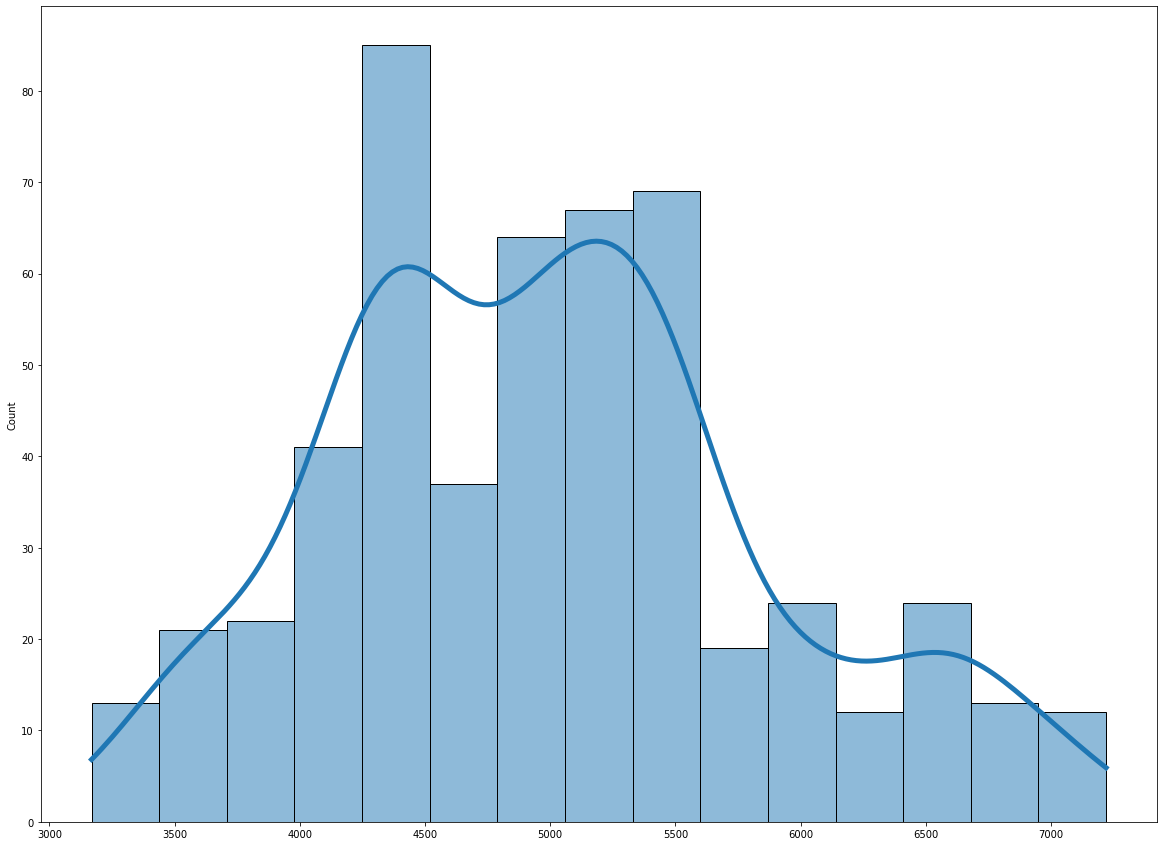

In [187]:
plt.figure(figsize=(20,15))
sns.histplot(data = cac40_1wk, kde=True, line_kws={"lw":5});

**CAC40 quotidien**

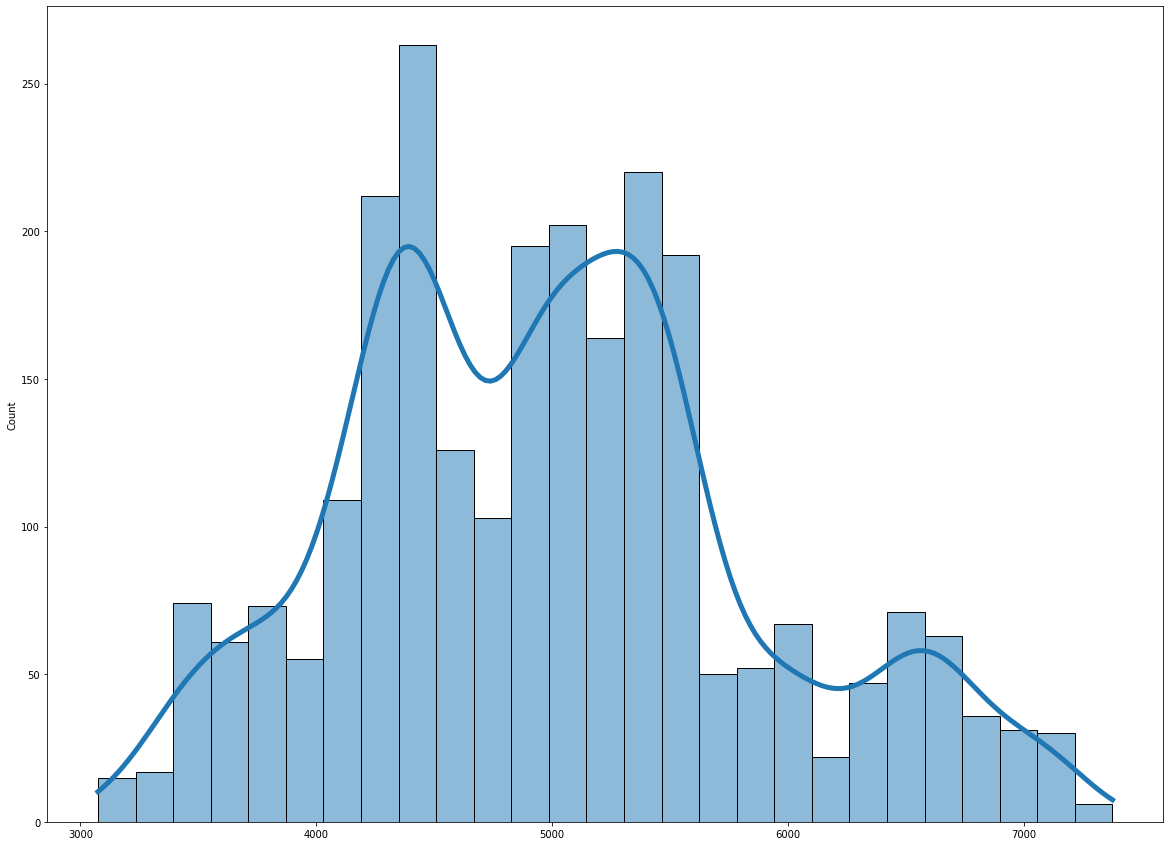

In [188]:
plt.figure(figsize=(20,15))
sns.histplot(data = cac40_1d, kde=True, line_kws={"lw":5});

On peut ainsi remarquer que pour une granularité faible, la distribution paraît vaguement gaussienne. Cependant, plus la granularité est élevée, plus cette distribution devient atypique et revèle des valeurs plus fréquentes que d'autres.

On va à présenter implémenter la mesure **Max Drawdown**. Pour rappel, il s'agit pour toute date <code>t</code> de prendre la valeur minimale jamais atteinte après cette date en pourcentage de la valeur à la date <code>t</code>.

In [189]:
def MaxDrawdown(data):
    
    return [(data[i] - np.min(data[i+1:]))/data[i]*100 for i in range(len(data) - 1)]

De plus, on décide d'effectuer cette analyse en prenant en compte différents points de départ.

In [190]:
def CreateSteps(data, n):

    return [int(i*len(data)/n) for i in range(n)]

Enfin, on code une fonction permettant d'afficher un graphique par jeu de donnée et par segment.

In [191]:
def plotMaxDrawdown(data, steps, show=True, name="CAC40"):
    list_of_values = []
    if show:
        fig, axes = plt.subplots(1, len(steps), figsize=(30,10))
    for i in range(len(steps)):
        values = MaxDrawdown(data[steps[i]:])
        list_of_values.append(values)
        if show:
            sns.histplot(data = values, kde=True, line_kws={"lw":5}, ax = axes[i])
            axes[i].set_title(name + " MDD starting from T = " + str(steps[i]), fontsize=20)
    return list_of_values

On affiche maintenant nos résultats. On se décide de segmenter les données en <code>4</code>.

**CAC40 mensuel**

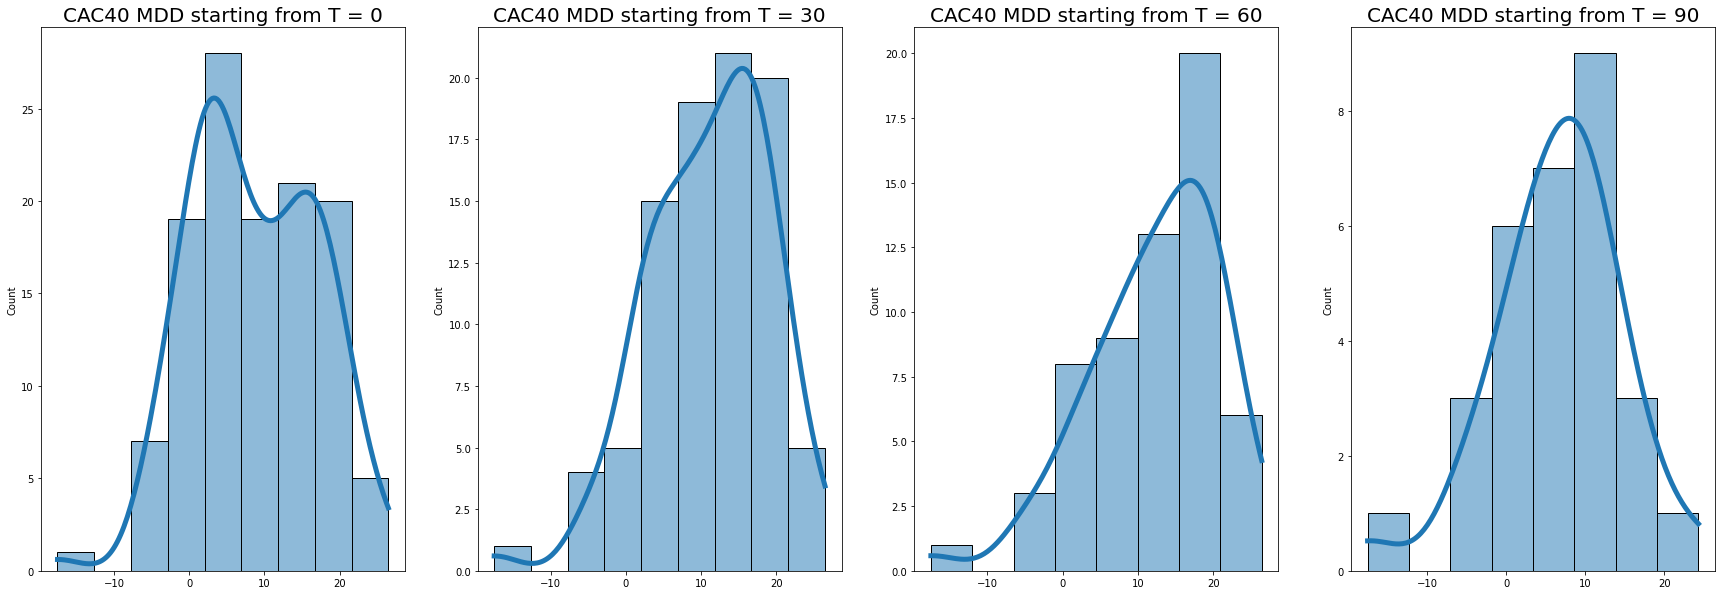

In [192]:
steps_1mo = CreateSteps(cac40_1mo, 4)
list_of_values_1mo = plotMaxDrawdown(cac40_1mo, steps_1mo)

**CAC40 hebdomadaire**

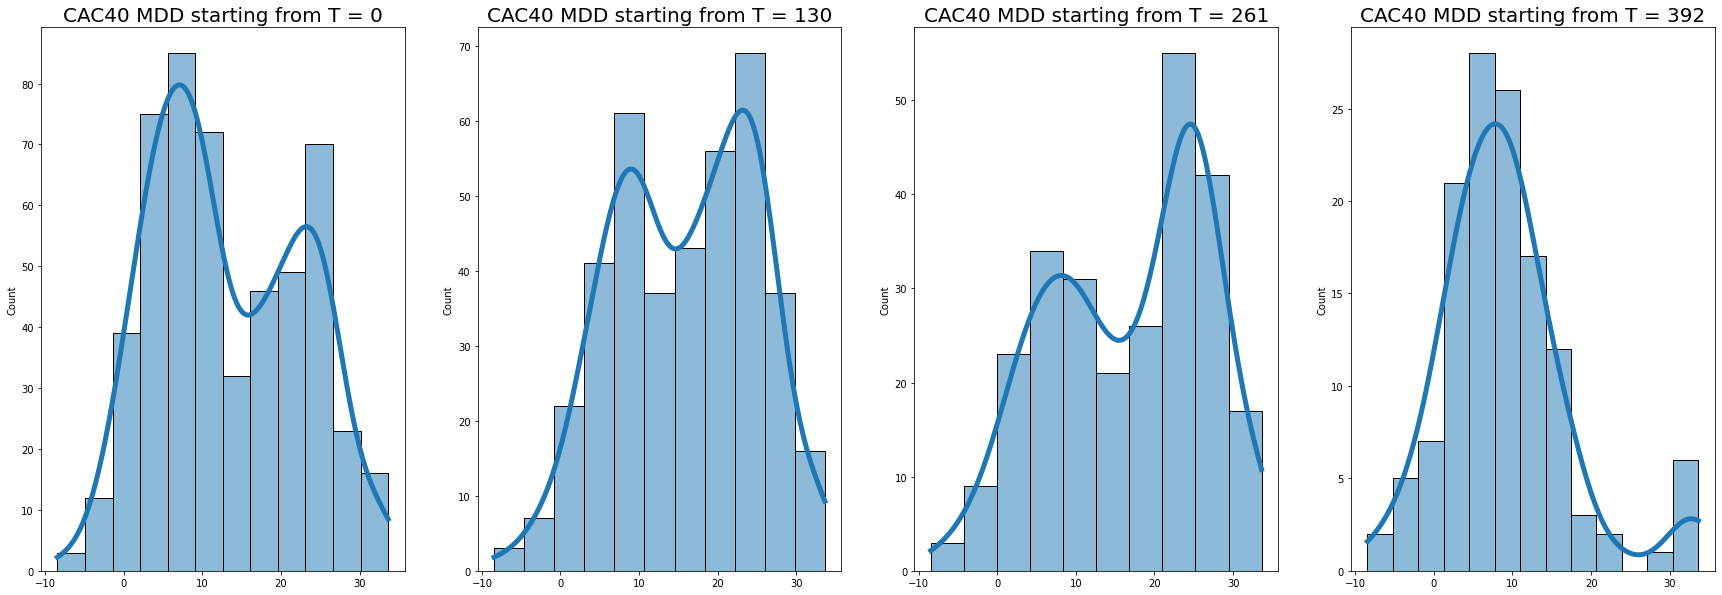

In [193]:
steps_1wk = CreateSteps(cac40_1wk, 4)
list_of_values_1wk = plotMaxDrawdown(cac40_1wk, steps_1wk)

**CAC40 quotidien**

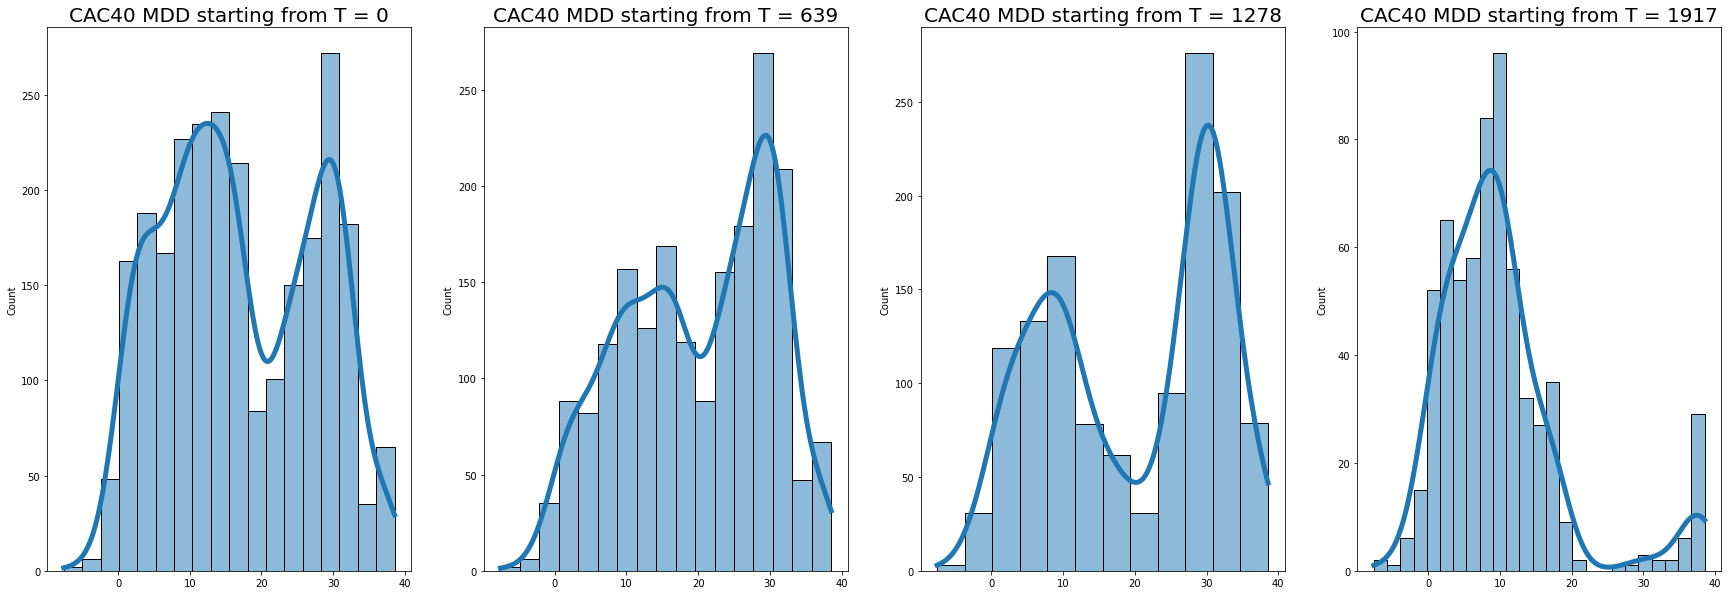

In [194]:
steps_1d = CreateSteps(cac40_1d, 4)
list_of_values_1d = plotMaxDrawdown(cac40_1d, steps_1d)

On décide maintenant de comparer ces différentes distributions, en calculant certaines statistiques descriptives en fonction de plusieurs temps de départ. On se fixe une granularité maximale quotidienne.

In [195]:
def GetBasicStats(data):
    
    return [np.min(data), np.max(data), np.mean(data), np.std(data)]

On affiche pour 100 segments, la progression des valeurs minimales, moyennes, médianes, maximales en fonction du point de départ.

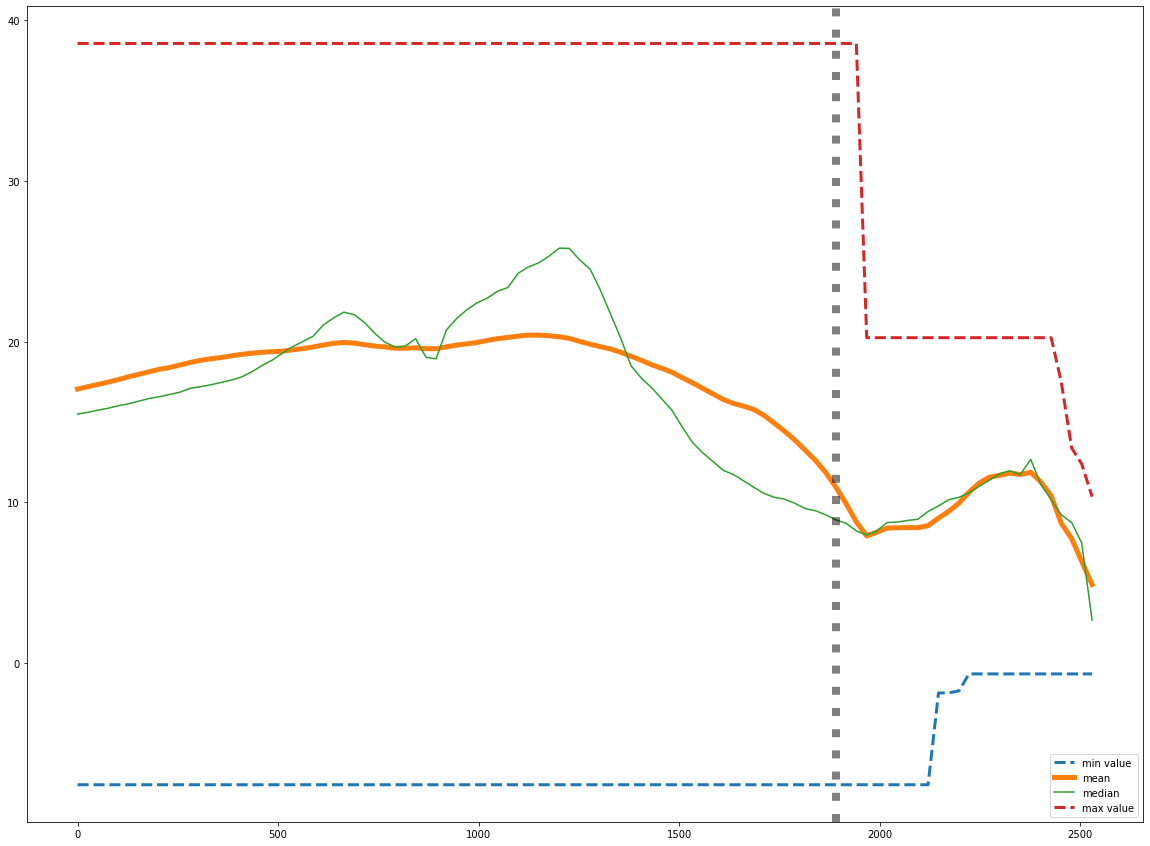

In [196]:
steps_1d = CreateSteps(cac40_1d, 100)
list_of_values_1d = plotMaxDrawdown(cac40_1d, steps_1d, False)

minimal = [np.min(list_of_values_1d[i]) for i in range(len(steps_1d))]
maximal = [np.max(list_of_values_1d[i]) for i in range(len(steps_1d))]
mean = [np.mean(list_of_values_1d[i]) for i in range(len(steps_1d))]
median = [np.median(list_of_values_1d[i]) for i in range(len(steps_1d))]
std = [np.std(list_of_values_1d[i]) for i in range(len(steps_1d))]

plt.figure(figsize=(20,15))
plt.plot(steps_1d, minimal, '--', label = "min value", lw=3);
plt.plot(steps_1d, mean, label = "mean", lw=5);
plt.plot(steps_1d, median, label = "median");
plt.plot(steps_1d, maximal, '--', label = "max value", lw=3);
plt.axvline(steps_1d[int(3*len(steps_1d)/4)-1],linestyle=':', lw=8, color="black", alpha = 0.5)
plt.legend(loc="lower right");


On remarque que la valeur maximale tend à décroître (notamment vers la fin) et la valeur minimale croître à la fin, ce qui est tout à fait normal étant donné la nature même du minimum et du maximum pour des ensembles emboîtés.  

Il s'agit surtout d'une indication quant à la forme de la distribution du Max Drawdown lorsque l'on dépasse le seuil des 75% de la période totale (ligne verticale) : la distribution se resserre subitement autour de la moyenne. 

Cela montre que la loi du Max Drawdown subit un changement soudain à partir de ce seuil de 75%.

On affiche aussi la progression de l'écart-type.

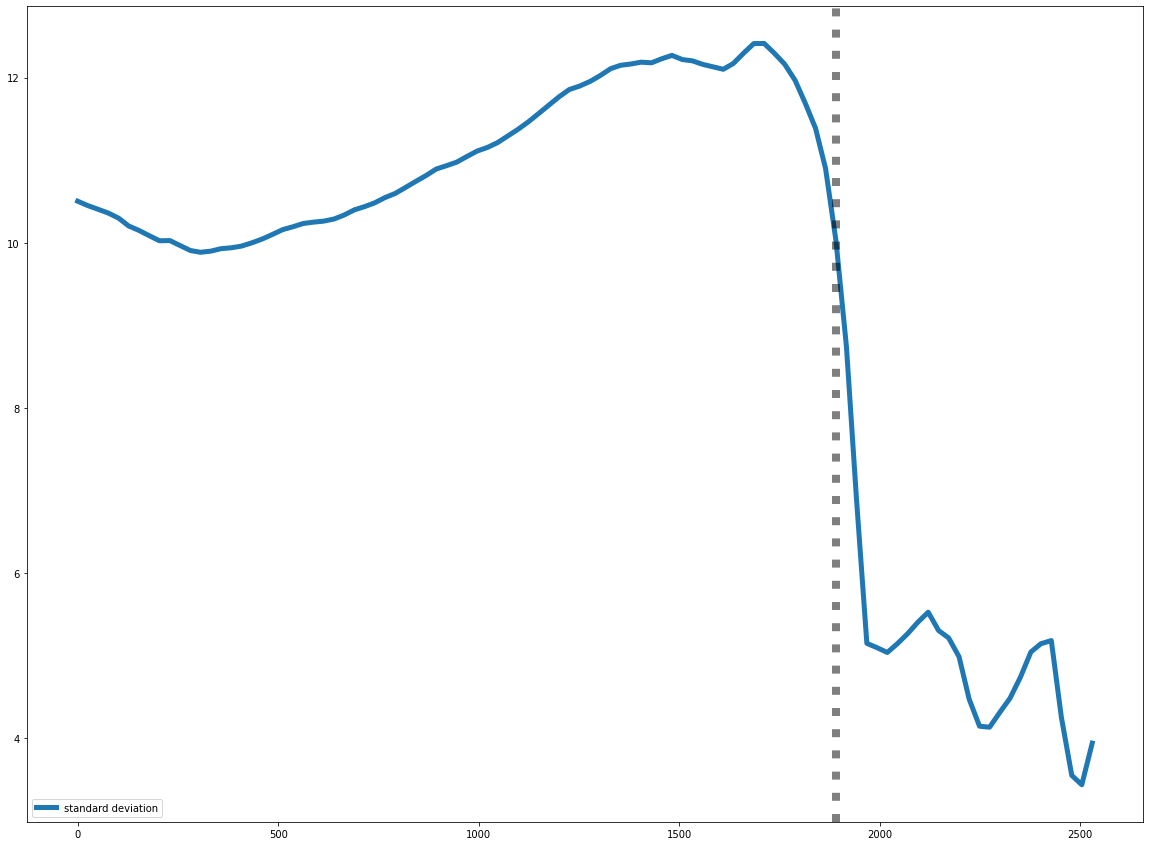

In [197]:
plt.figure(figsize=(20,15))
plt.plot(steps_1d, std, label = "standard deviation", lw=5);
plt.axvline(steps_1d[int(3*len(steps_1d)/4)-1],linestyle=':', lw=8, color="black", alpha = 0.5)
plt.legend(loc="lower left");


Comme on peut le voir ci-dessus, la variance décroît subitement à partir du seuil de 75%, confirmant ainsi une réduction de la dispersion de cette loi.

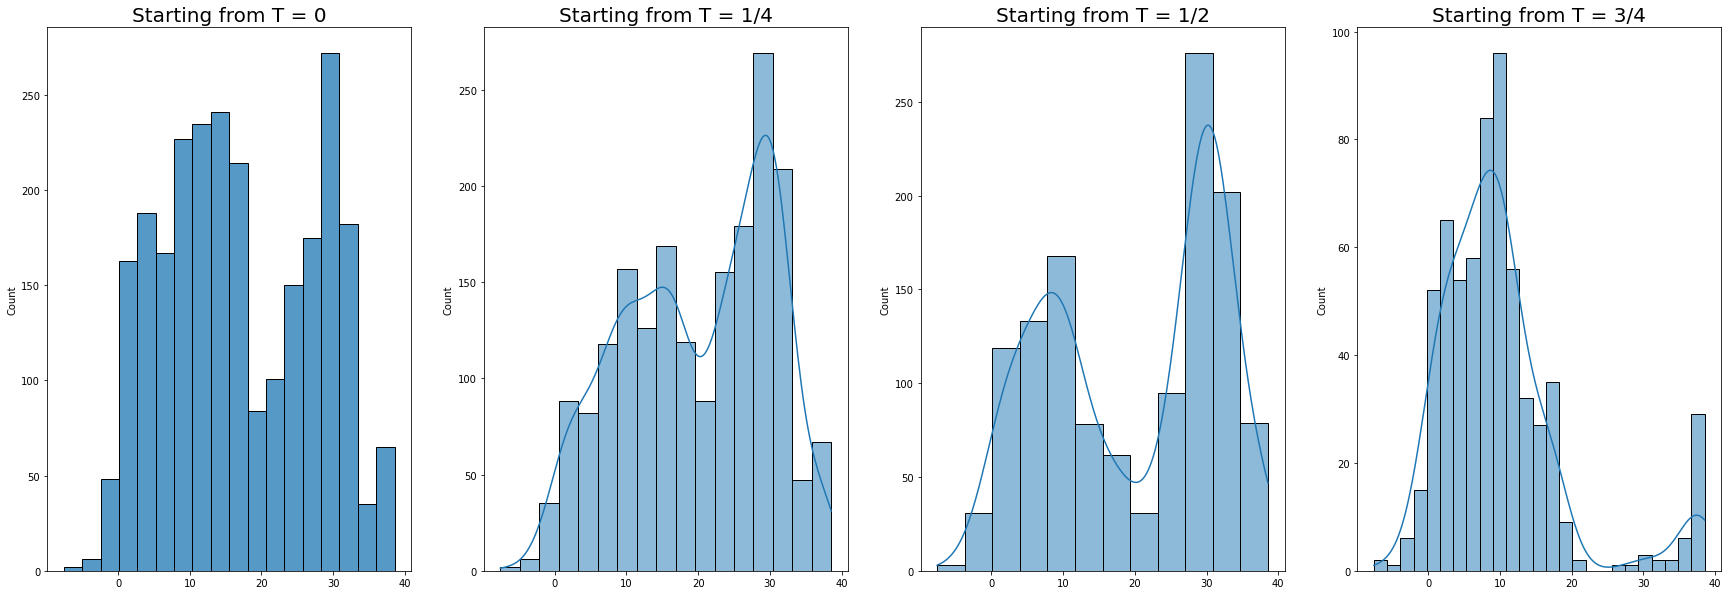

In [198]:
fig, axes = plt.subplots(1, 4, figsize=(30,10));
sns.histplot(list_of_values_1d[0], ax = axes[0]);
axes[0].set_title("Starting from T = 0", fontsize=20);
sns.histplot(list_of_values_1d[int(len(steps_1d)/4)], kde=True, ax = axes[1]);
axes[1].set_title("Starting from T = 1/4", fontsize=20);
sns.histplot(list_of_values_1d[int(len(steps_1d)/2)], kde=True, ax = axes[2]);
axes[2].set_title("Starting from T = 1/2", fontsize=20);
sns.histplot(list_of_values_1d[int(3*len(steps_1d)/4)], kde=True, ax = axes[3]);
axes[3].set_title("Starting from T = 3/4", fontsize=20);

On peut voir ci-dessus la progression de l'histogramme du Max Drawdown qui confirme nos observations précédentes. Il est à noter que cette loi a l'air bimodale, un premier mode à <code>10</code> et un deuxième à <code>30</code> qui devient négligeable une fois le seuil à 75% atteint.

Afin de confirmer nos hypothèses, nous faisons un test de similitude des distributions qui précèdent le seuil à 75%, à l'aide du test de Kolmogorov-Smirnov. Pour des raisons de temps d'exécution, on se contentera de comparer 2 à 2 dix distributions du Max Drawdown (0%, 10%, ..., 90%).

<AxesSubplot:>

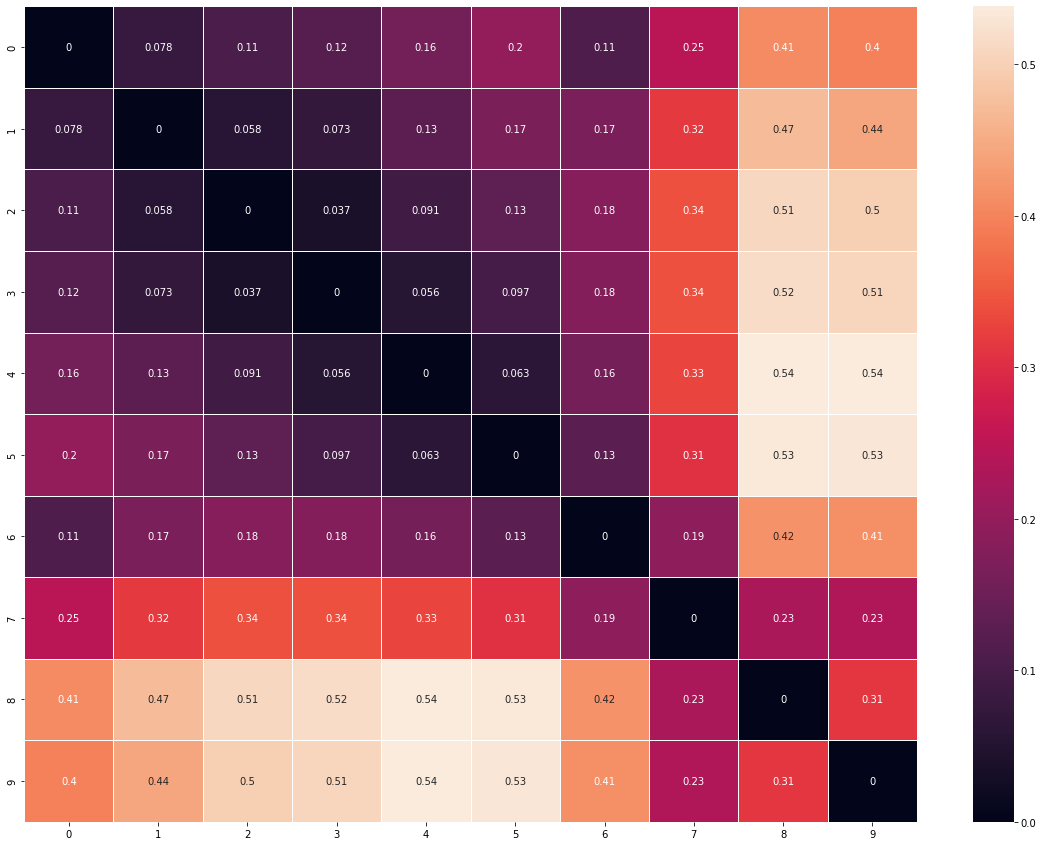

In [199]:
from scipy.stats import ks_2samp as ks
steps_1d = CreateSteps(cac40_1d, 10)
list_of_values_1d = plotMaxDrawdown(cac40_1d, steps_1d, False)
matrix_pvalues = np.array([  [ ks(list_of_values_1d[i], list_of_values_1d[j])[0] for i in range(len(steps_1d))] for j in range(len(steps_1d))])
plt.figure(figsize=(20,15))
sns.heatmap(matrix_pvalues, linewidth=0.5, annot=True)

On remarque bien une différenciation entre les distributions en dessous du seuil à 75% et celles au dessus.

On cherche à présent à effectuer cette analyse, mais sur un ensemble de 20 actions différentes. Voici la liste des tickers correspondants :

In [200]:
list_of_tickers =  ["AAPL",
                    "MSFT",
                    "GOOG",
                    "AMZN",
                    "TSLA",
                    "JNJ",
                    "META",
                    "NVDA",
                    "MA",
                    "PFE",
                    "KO",
                    "AZN",
                    "ORCL",
                    "MCD",
                    "CSCO",
                    "NKE",
                    "ADBE",
                    "ASML",
                    "PEP",
                    "INTC"
                    ]

/var/folders/6g/78y83rnn7710gp1v_nf7_d900000gn/T/ipykernel_9693/1027085901.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(1, len(steps), figsize=(30,10))


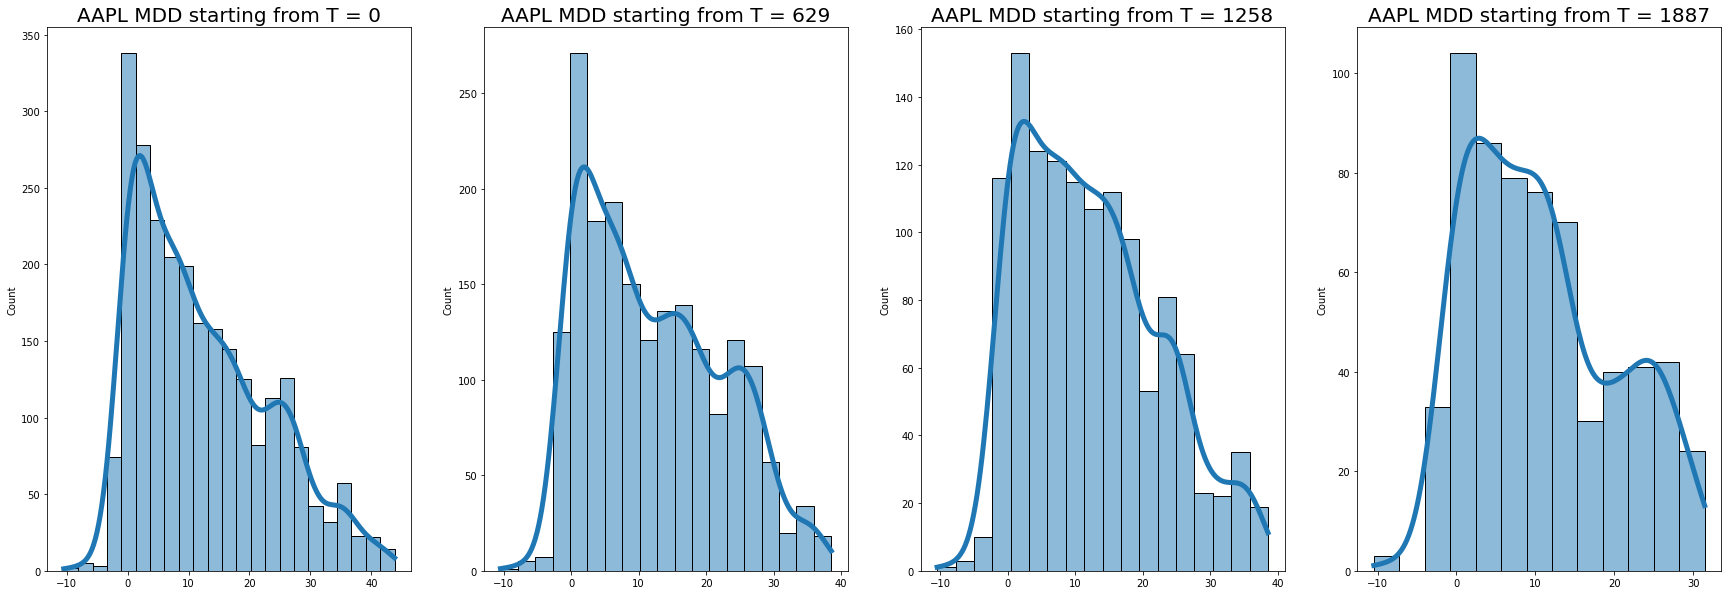

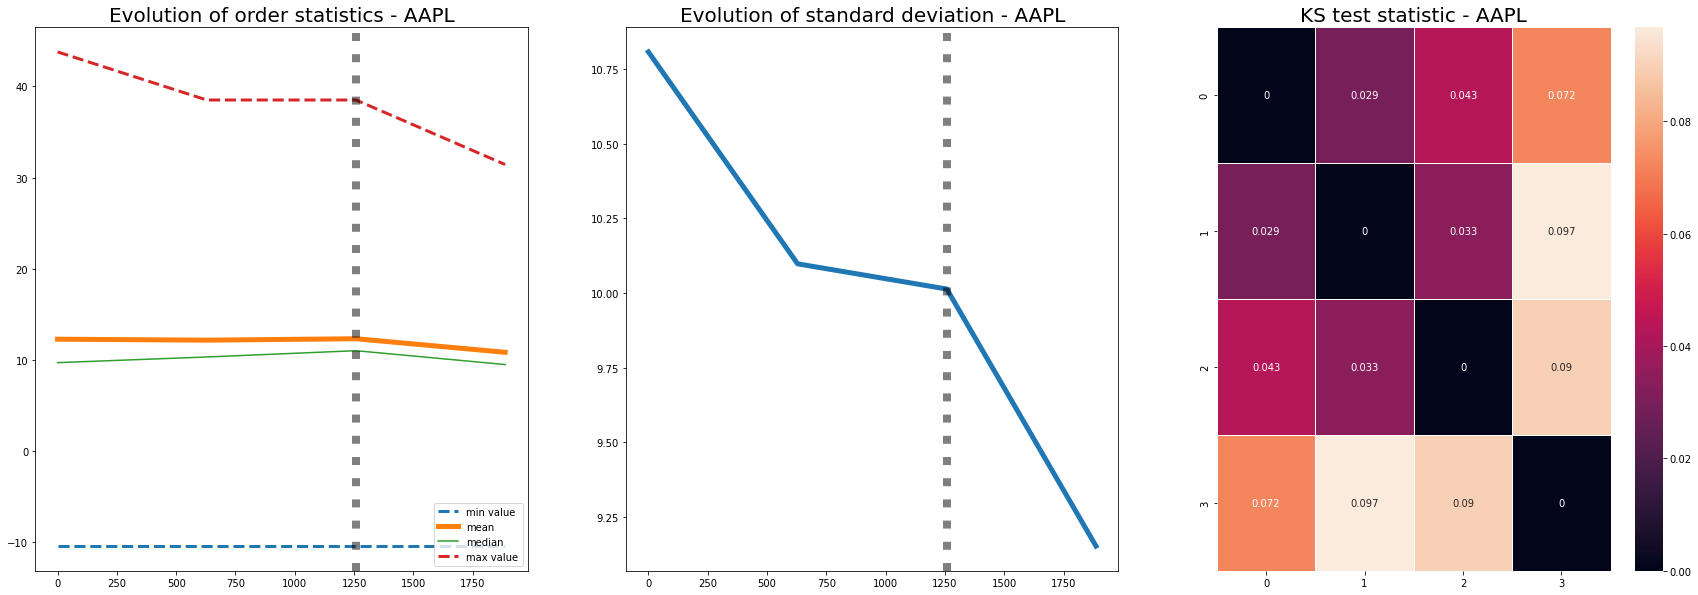

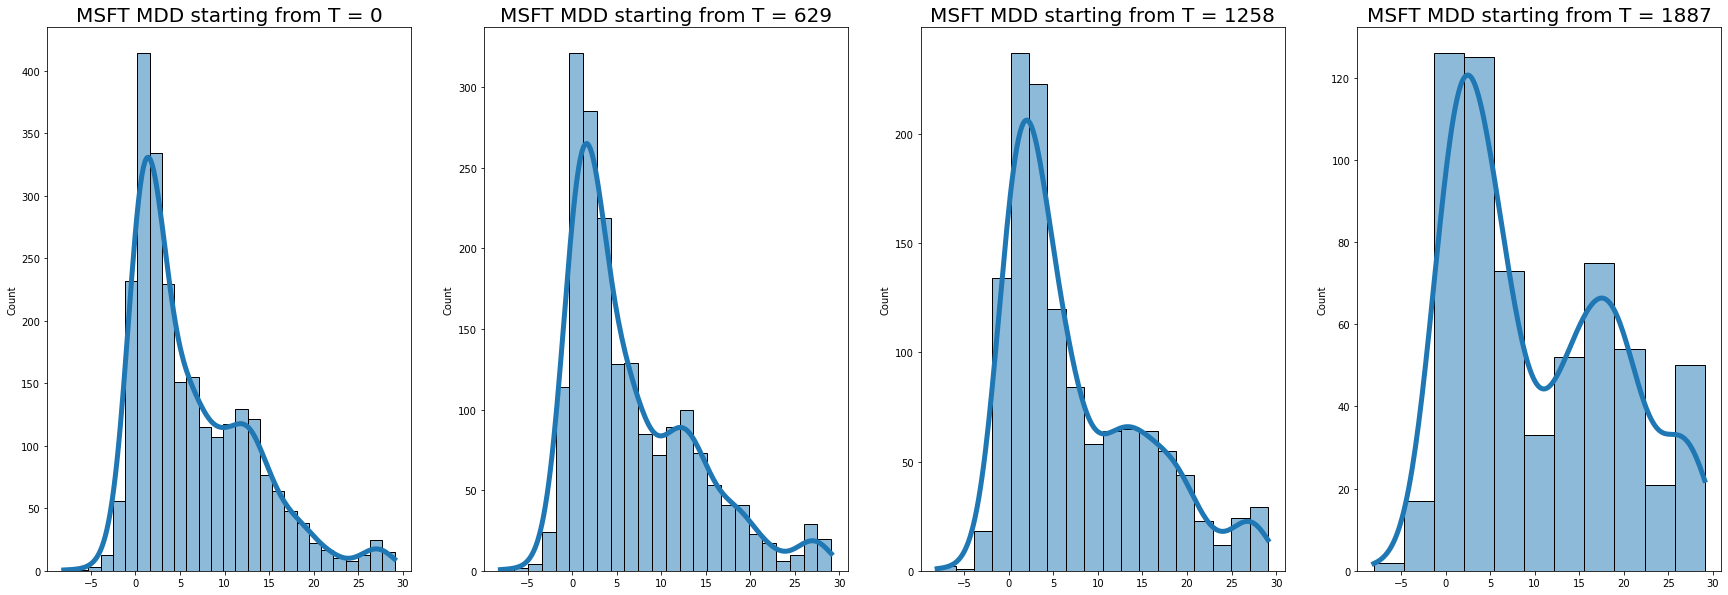

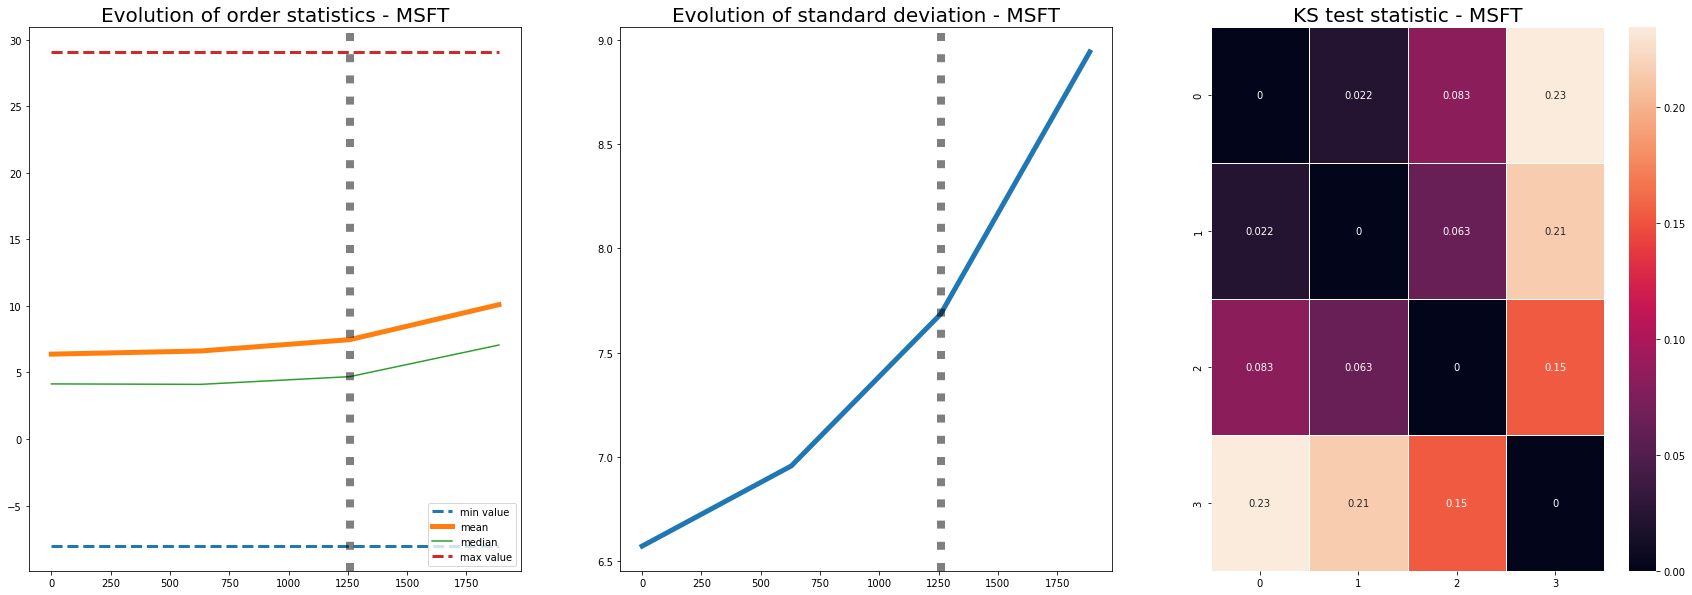

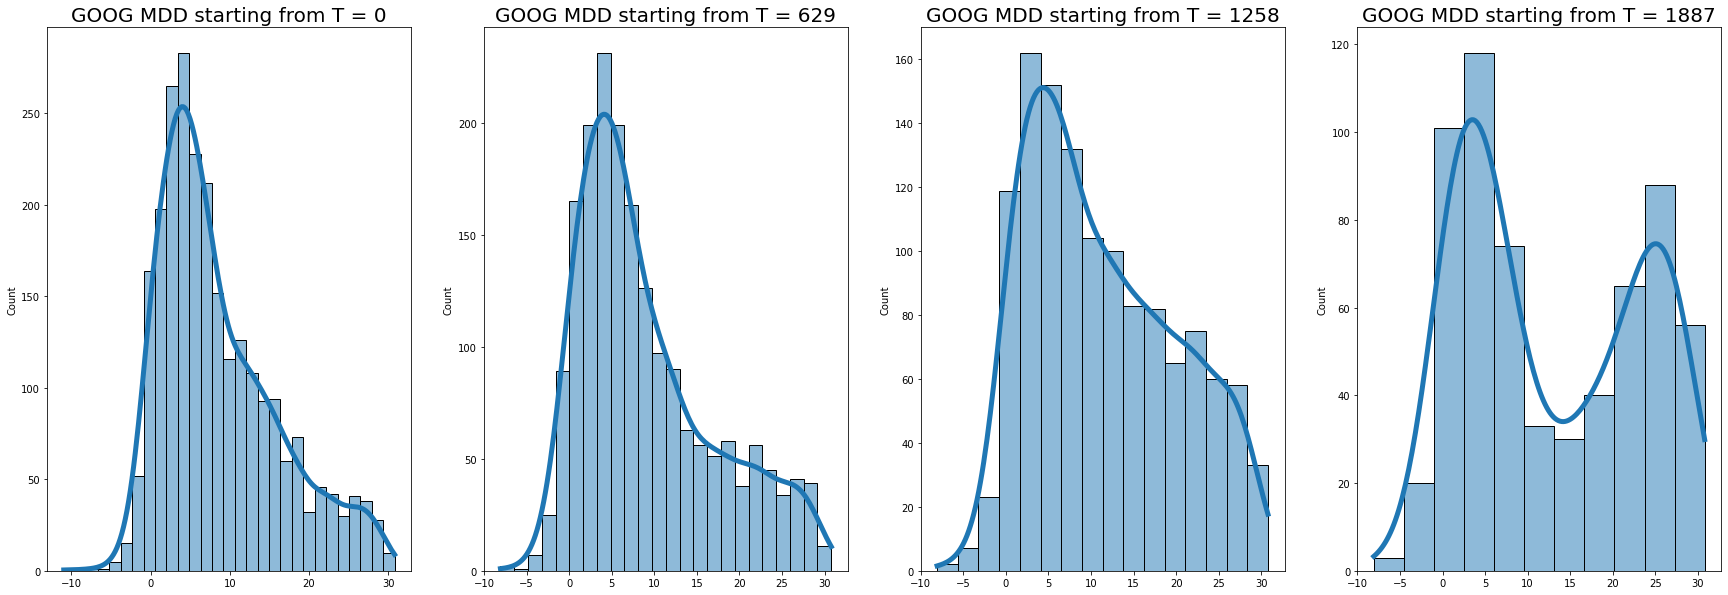

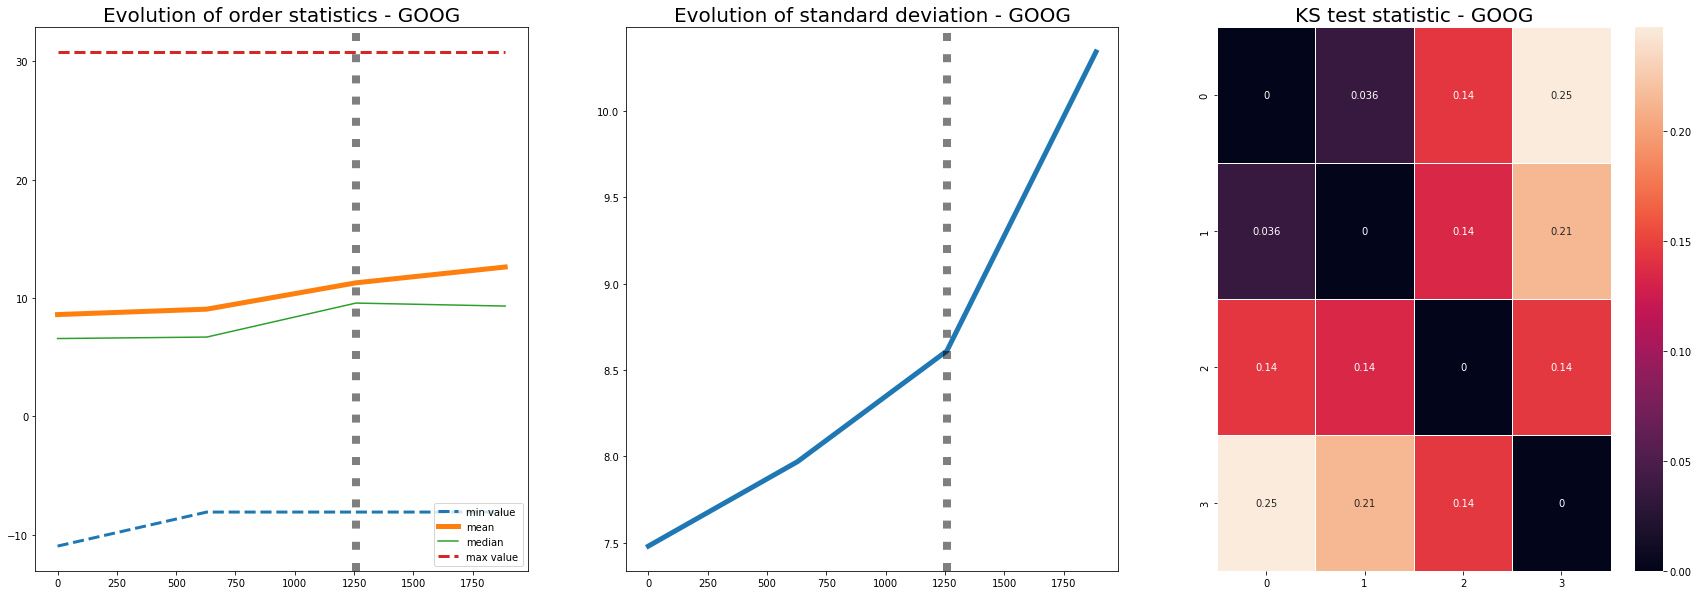

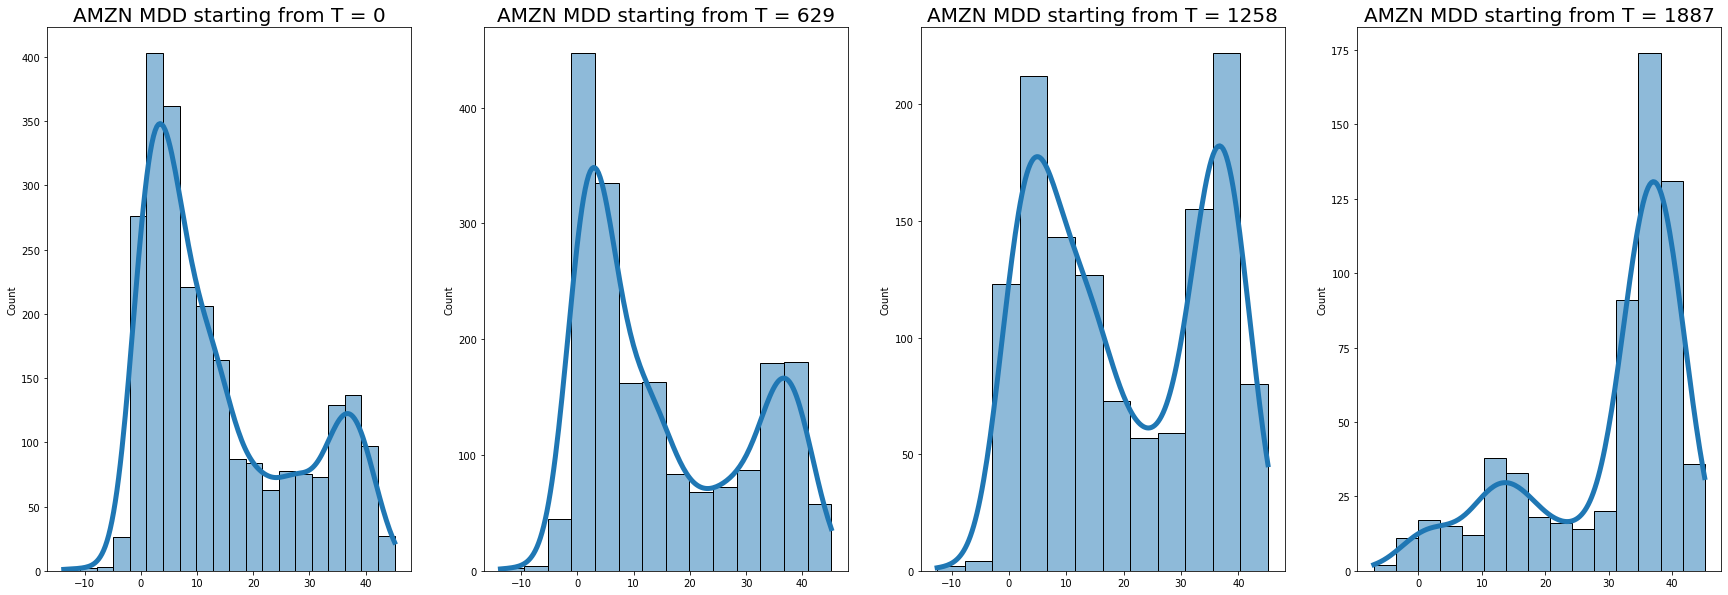

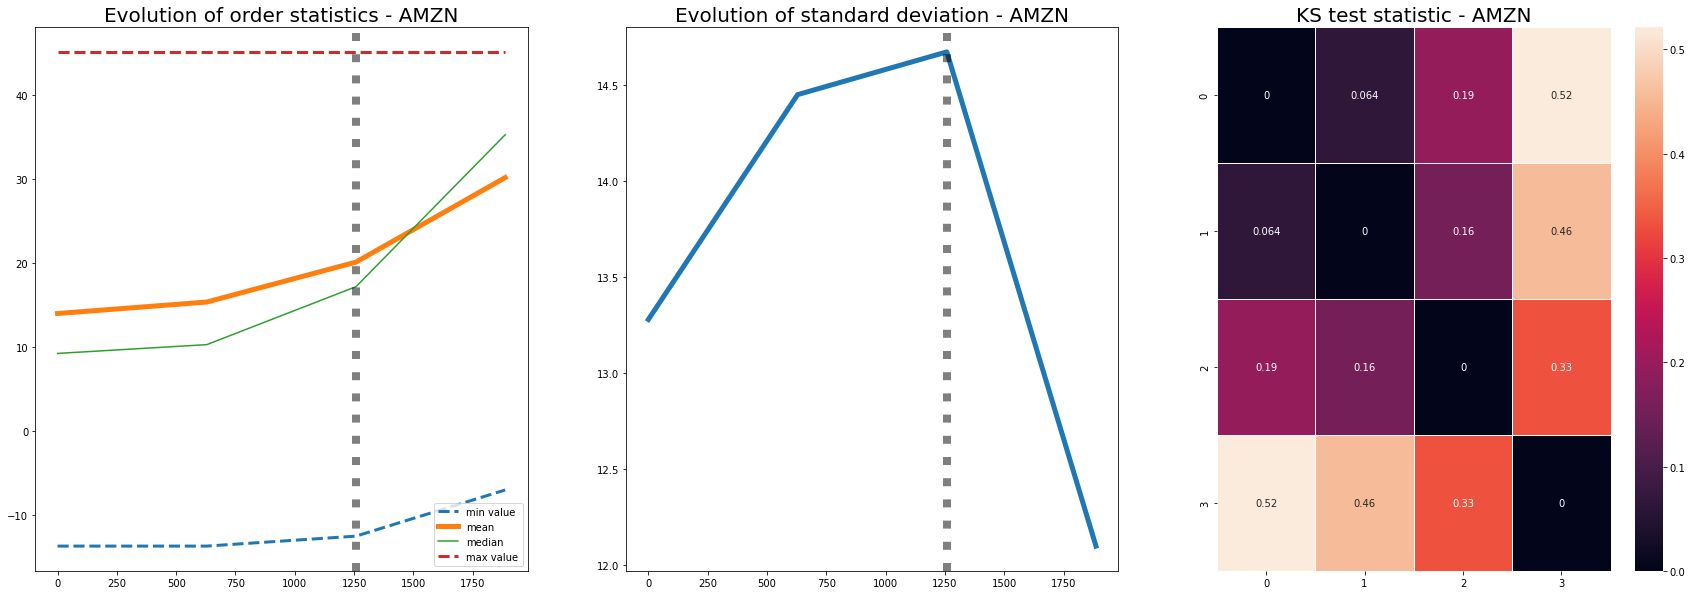

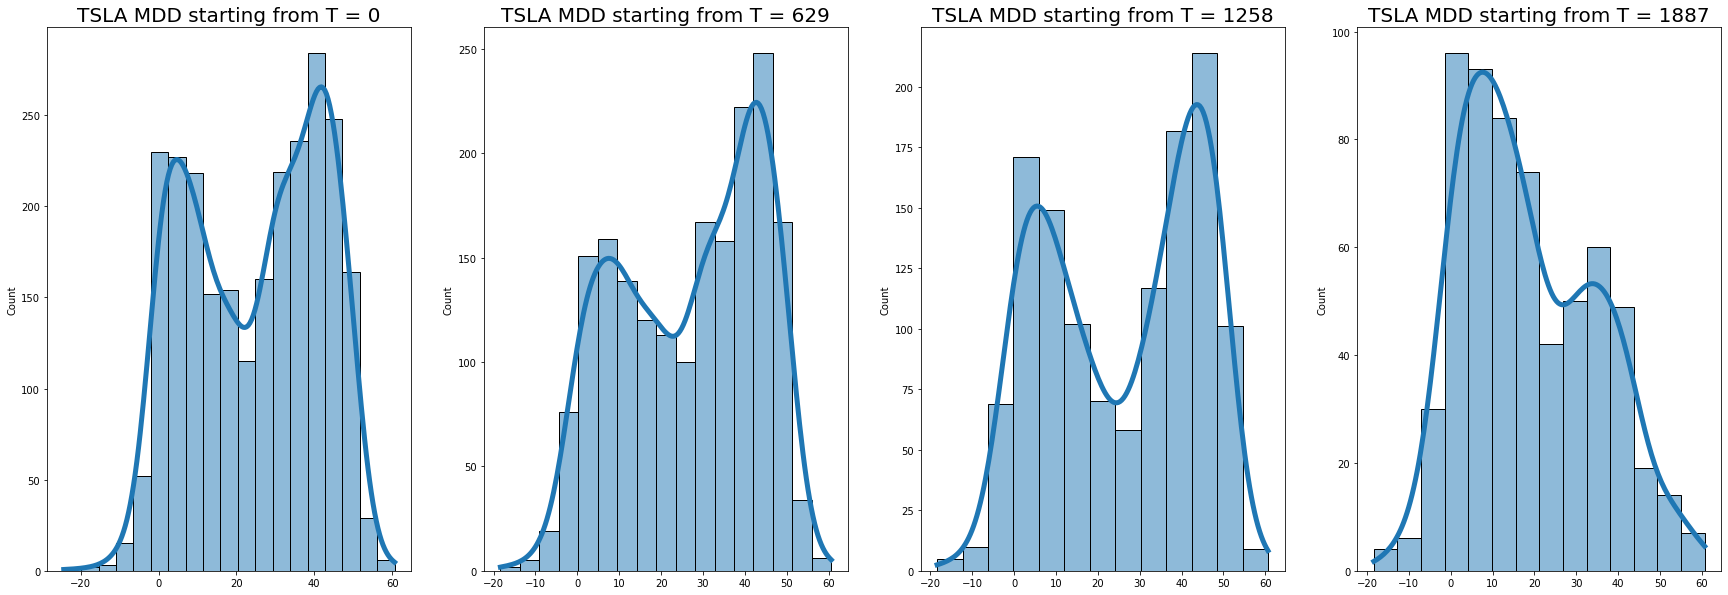

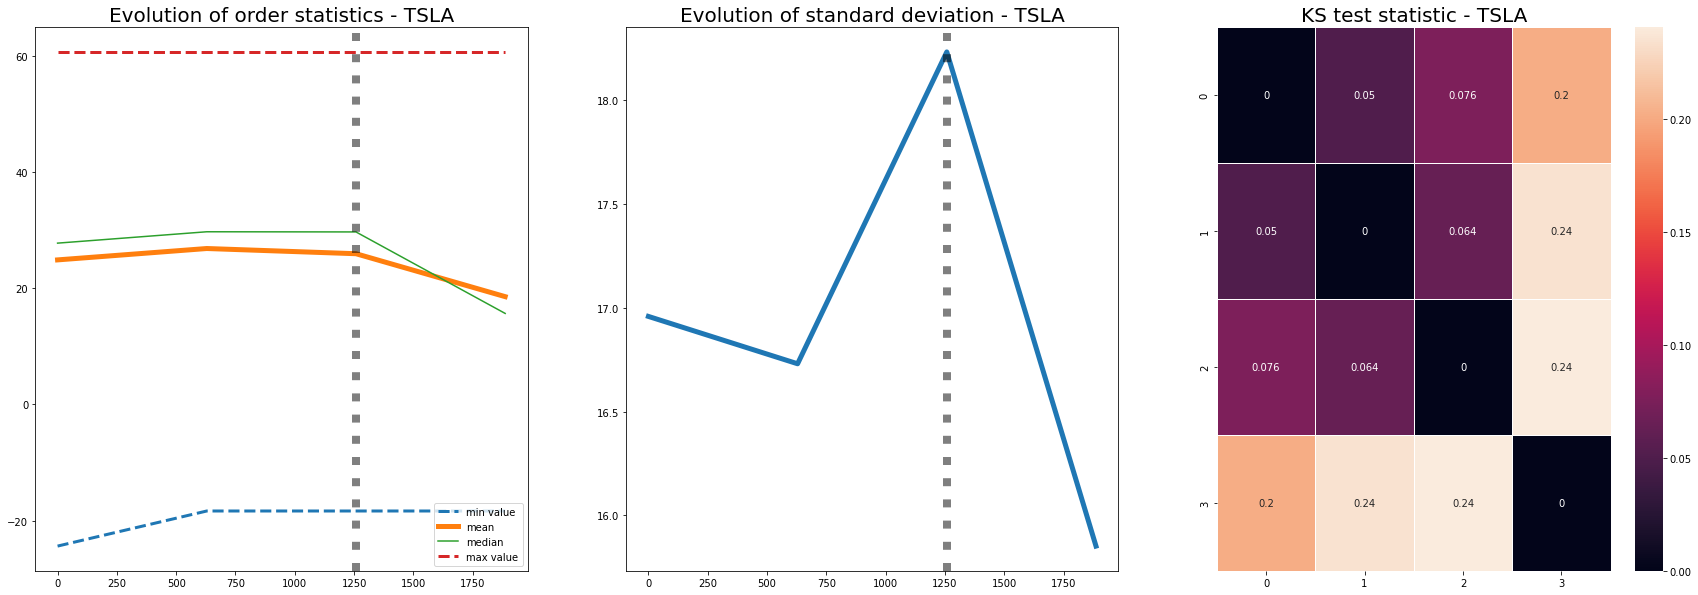

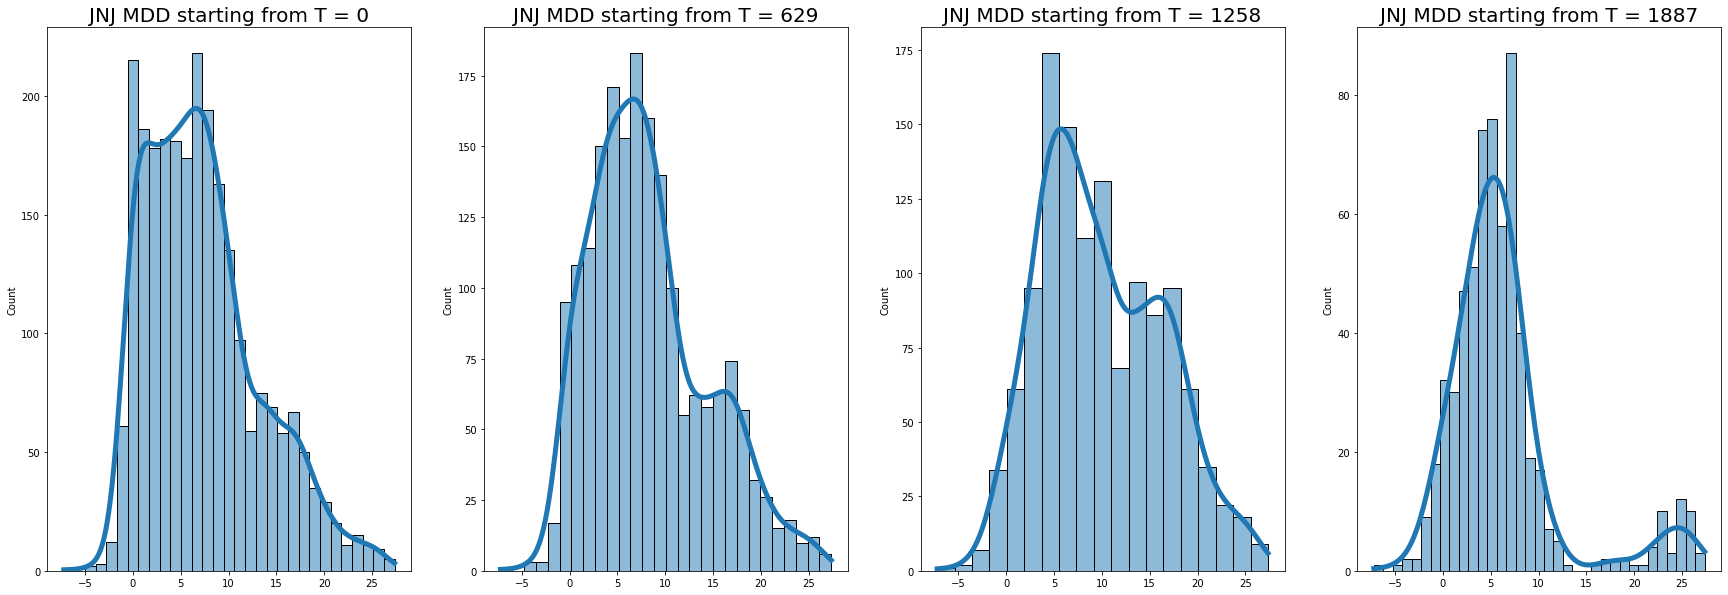

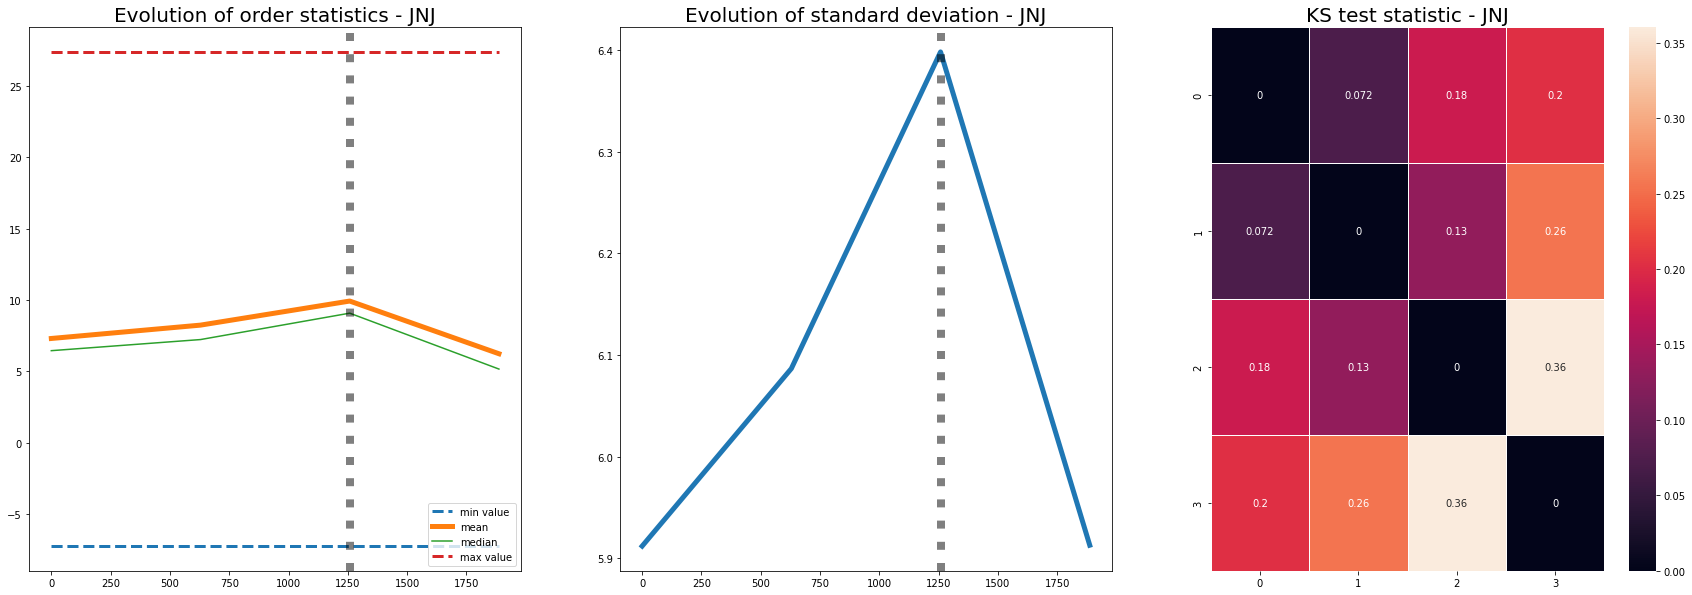

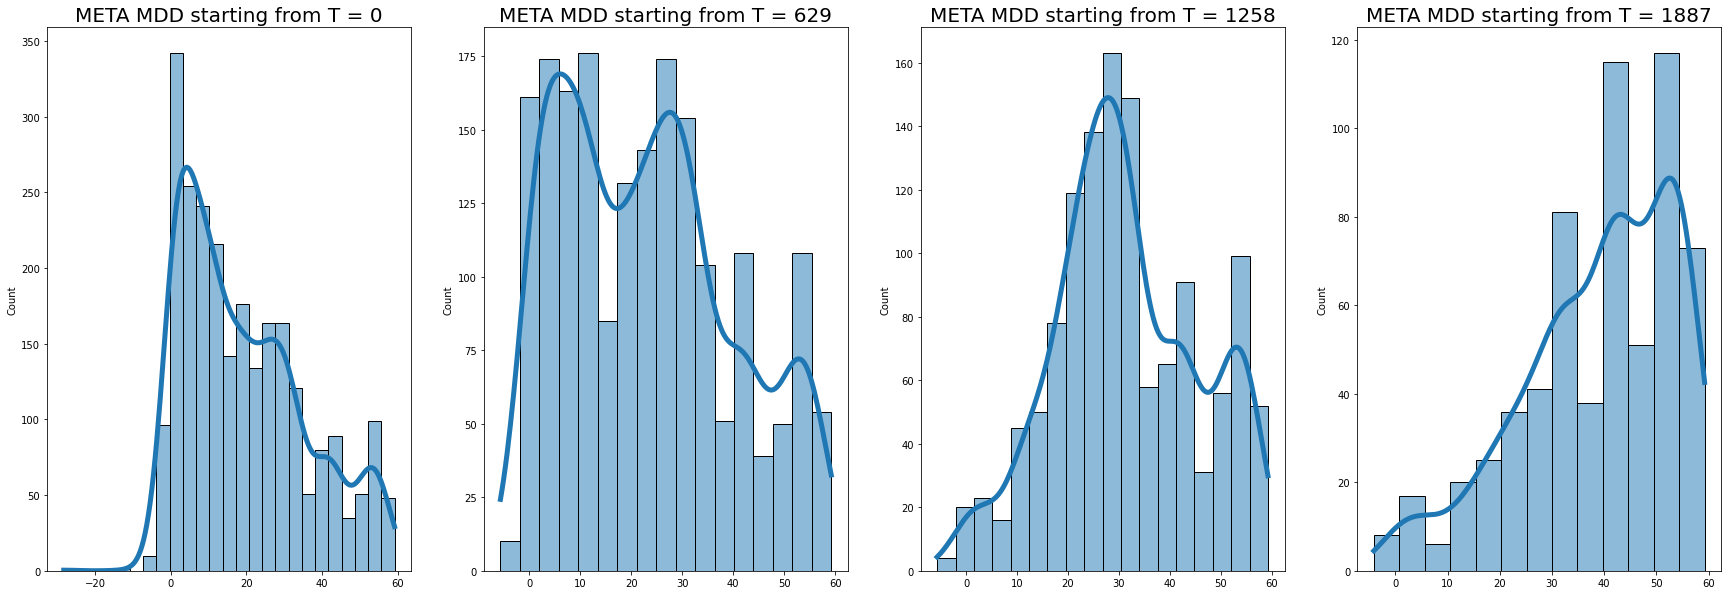

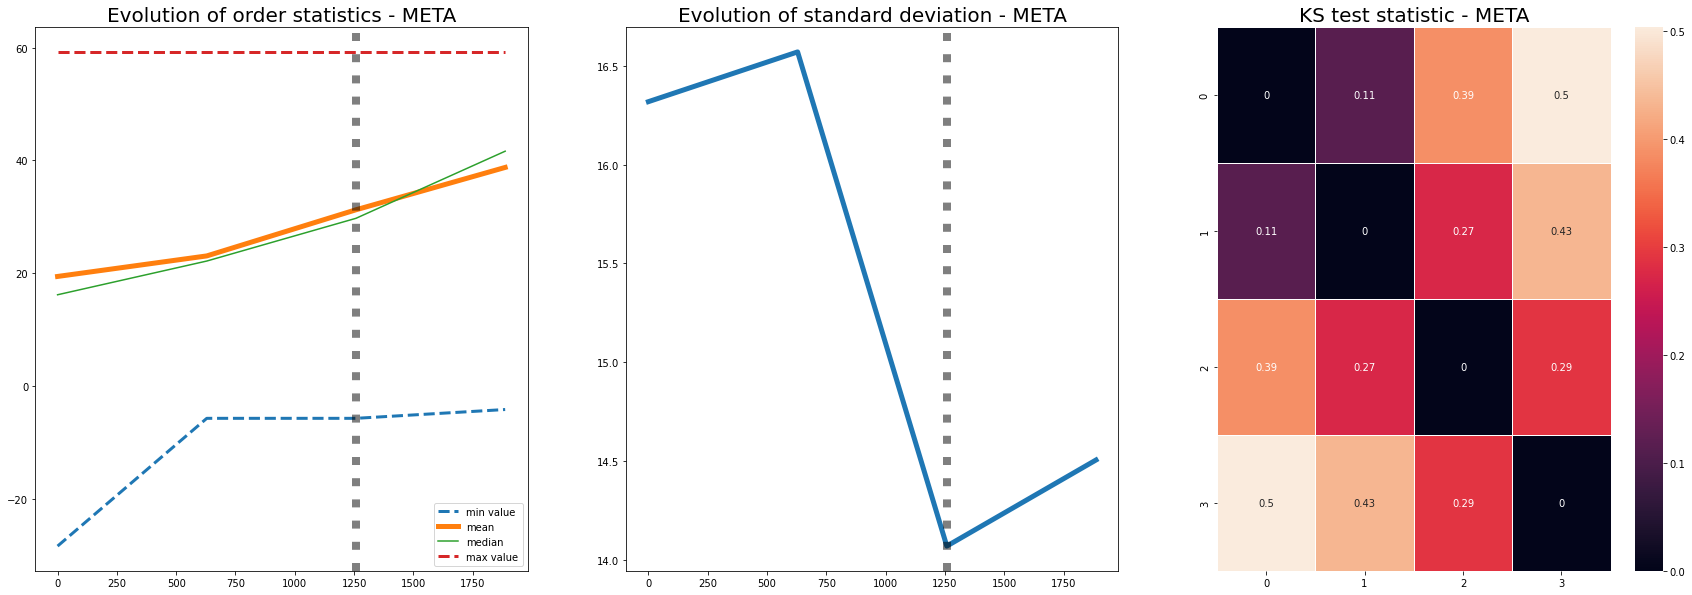

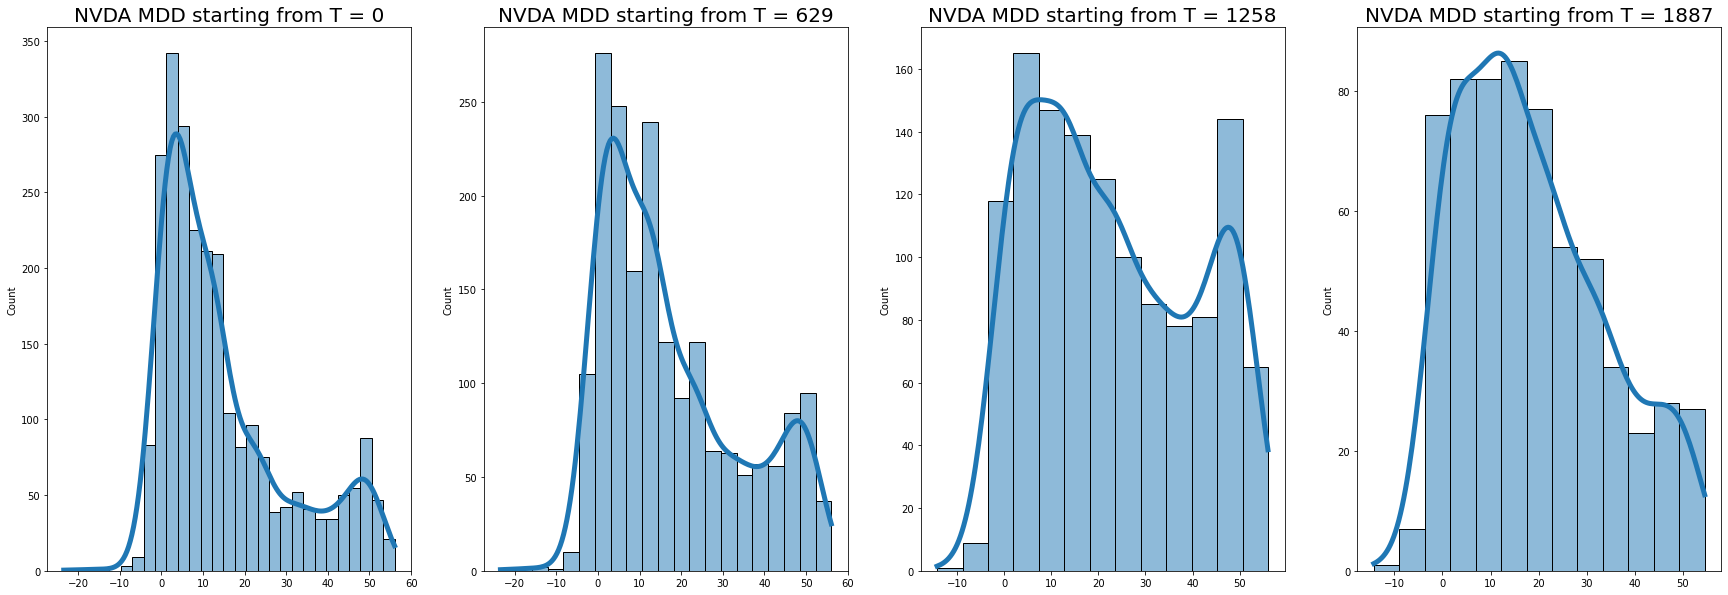

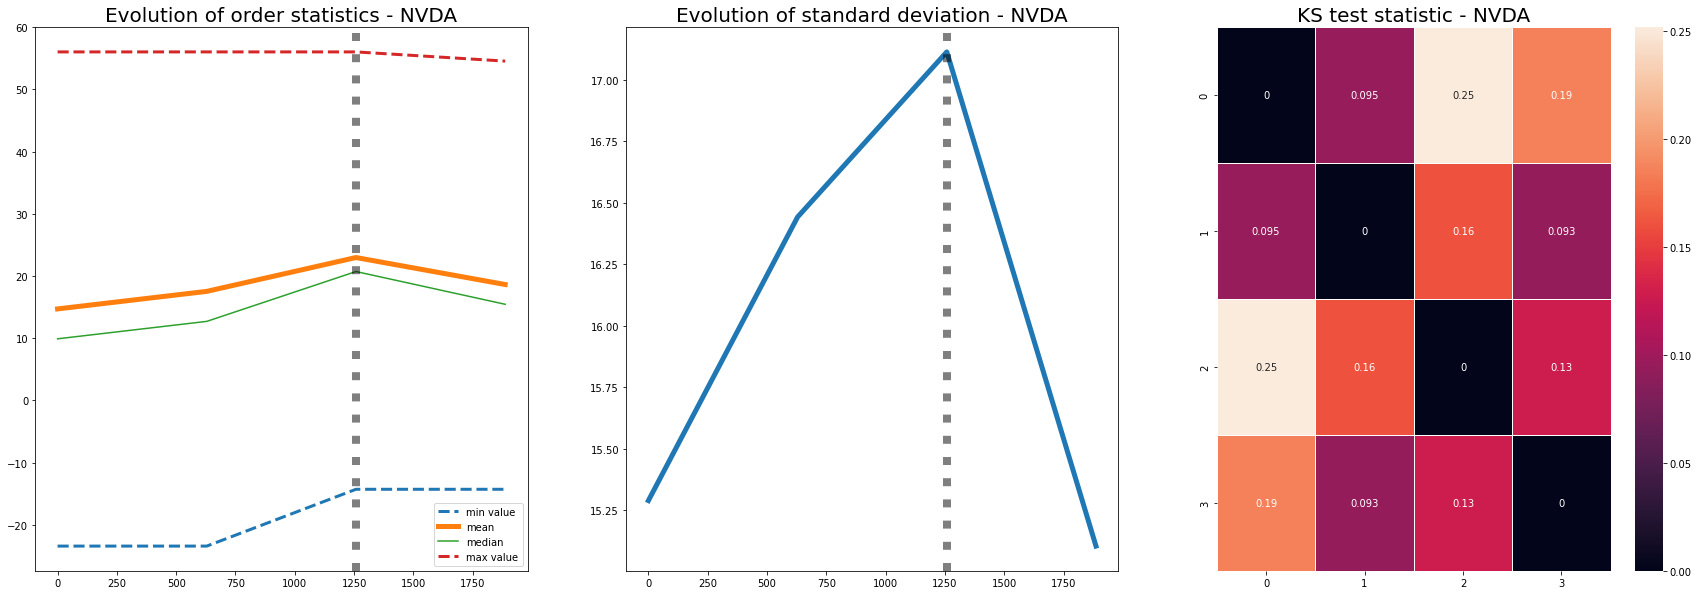

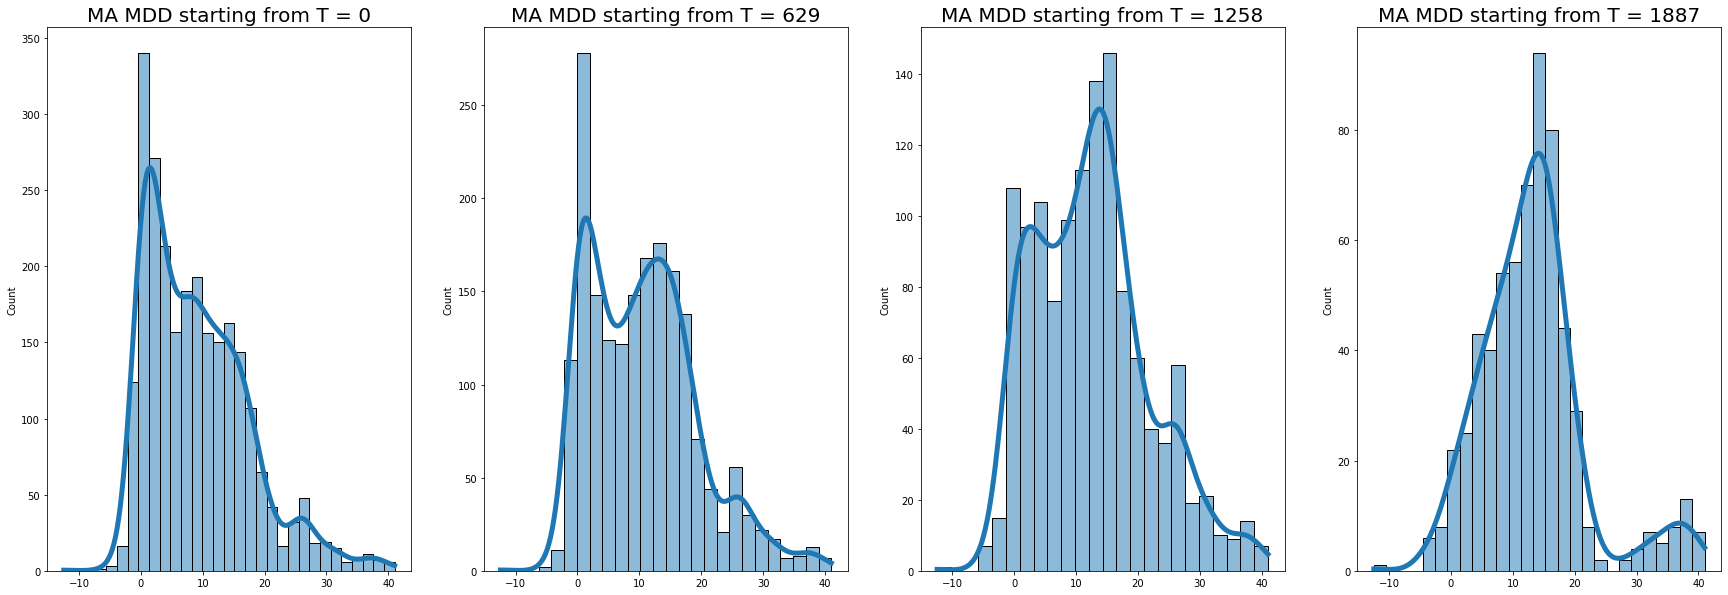

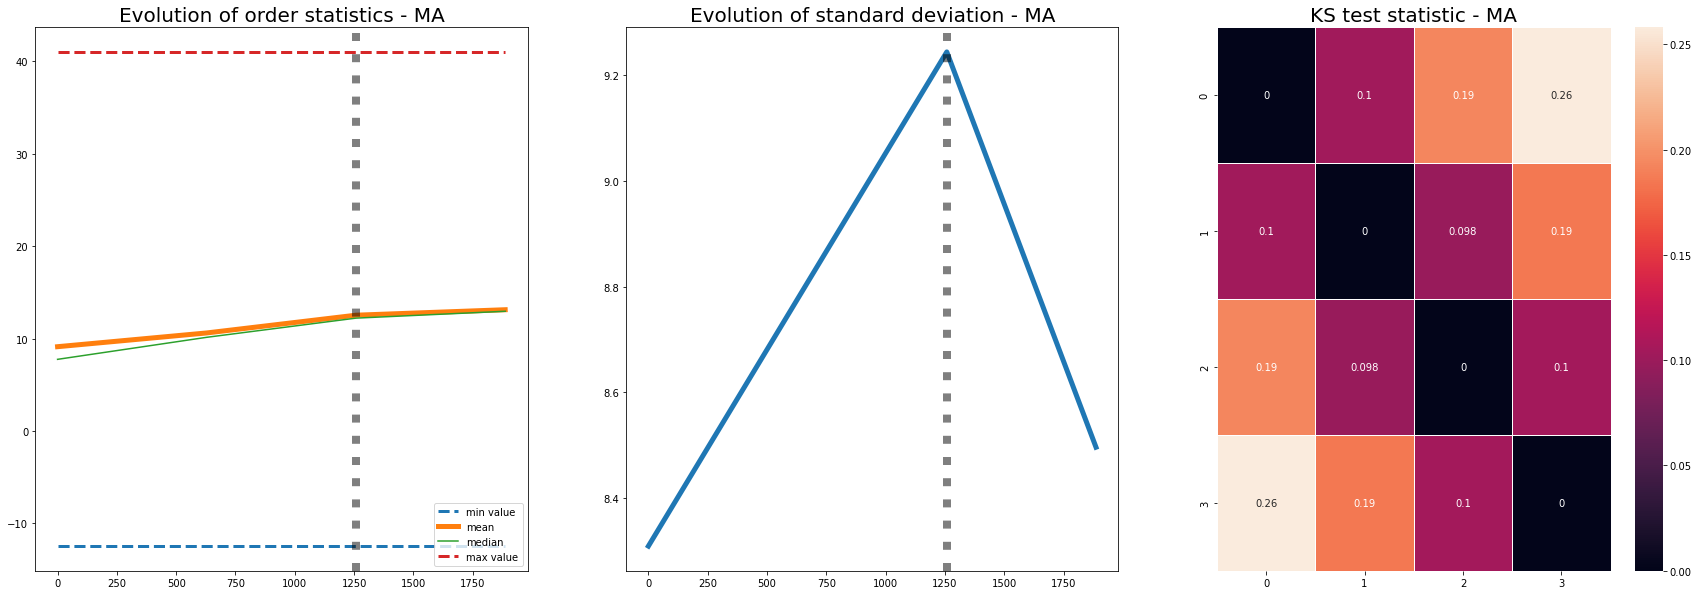

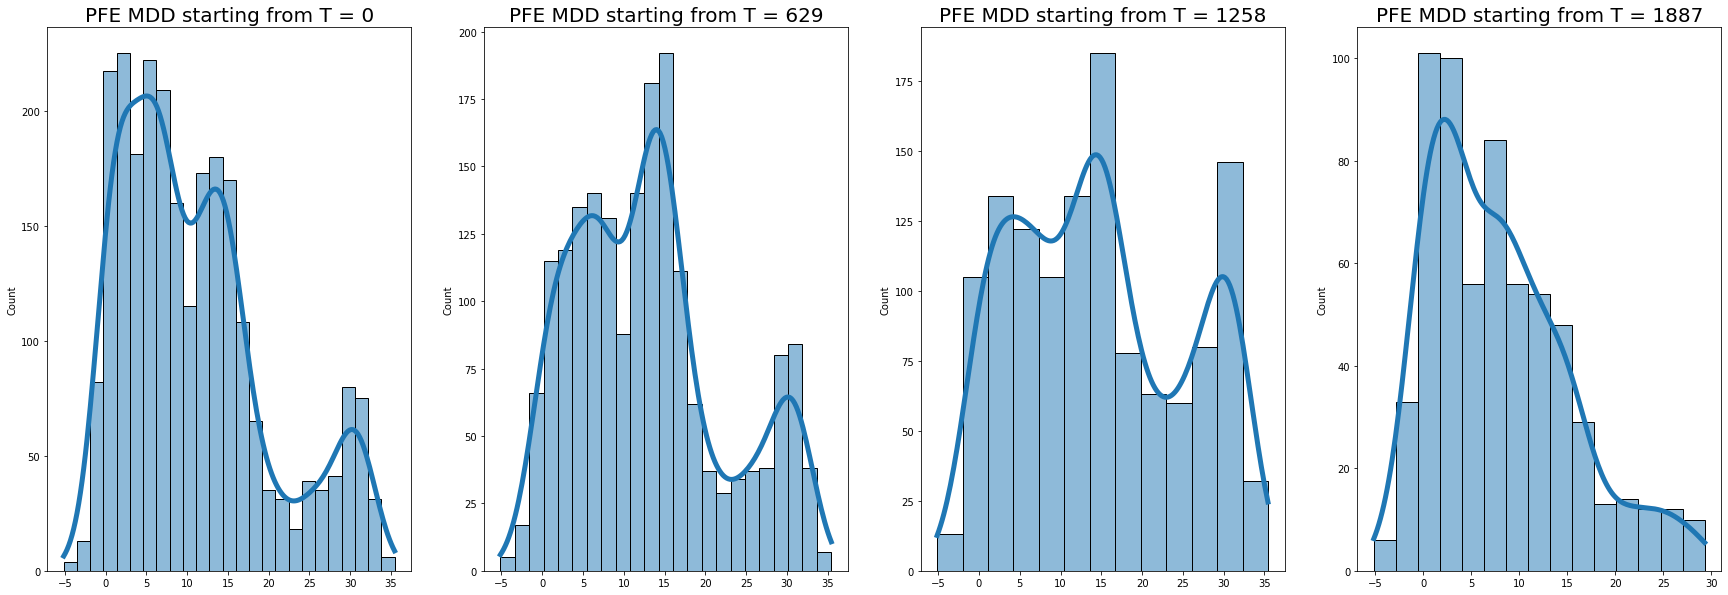

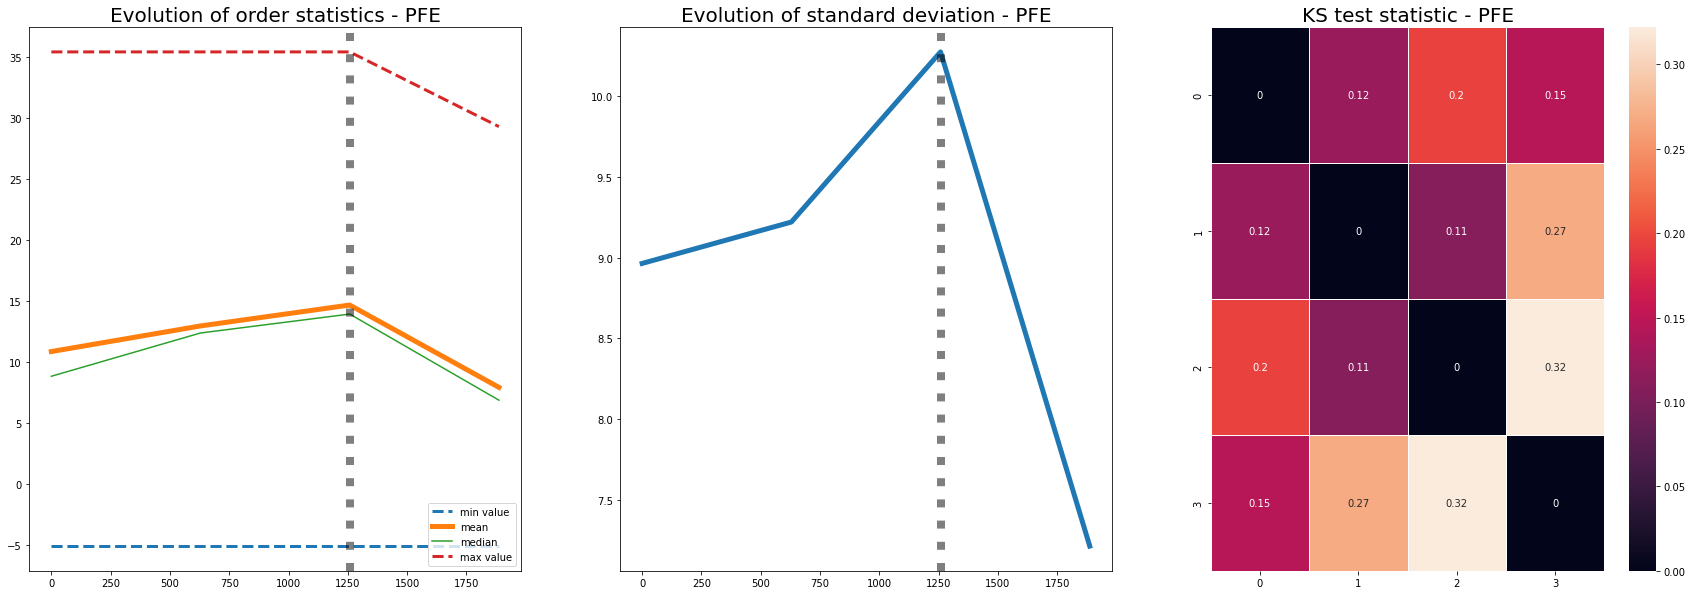

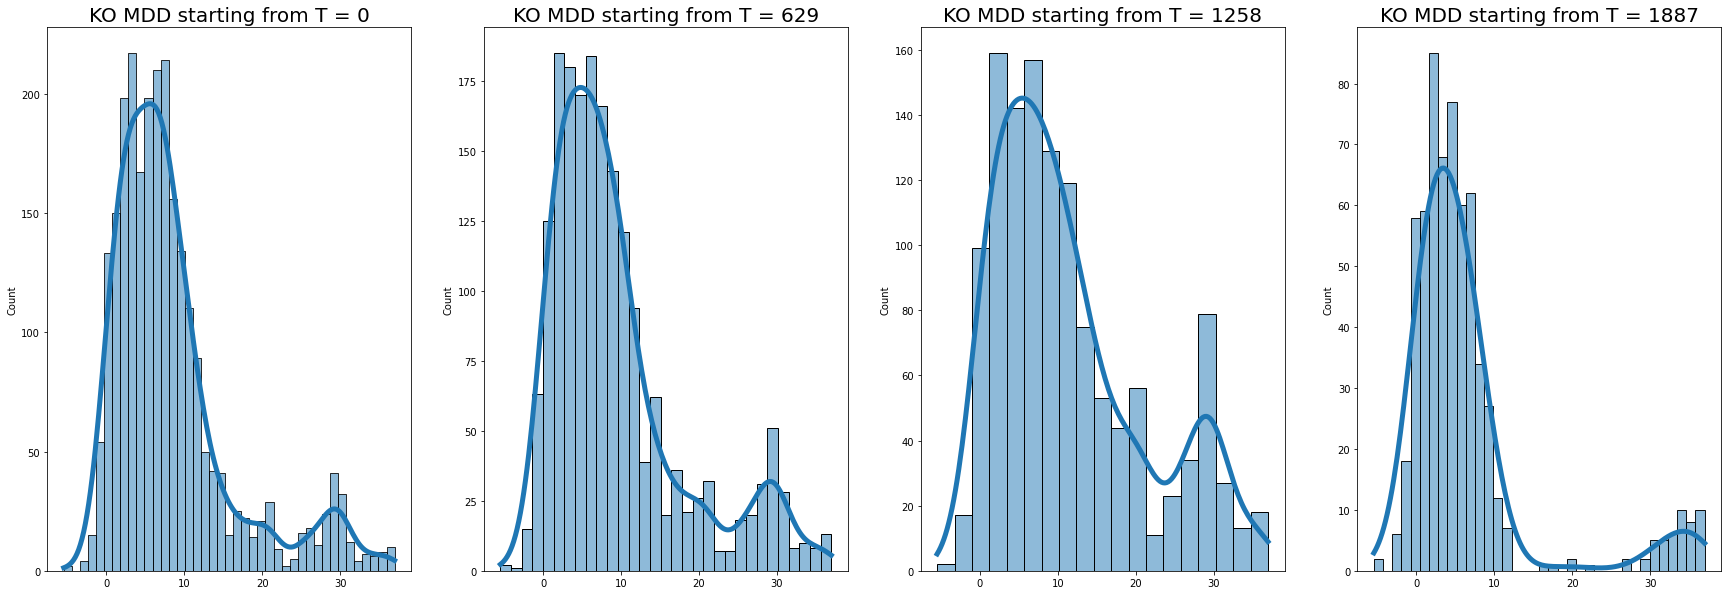

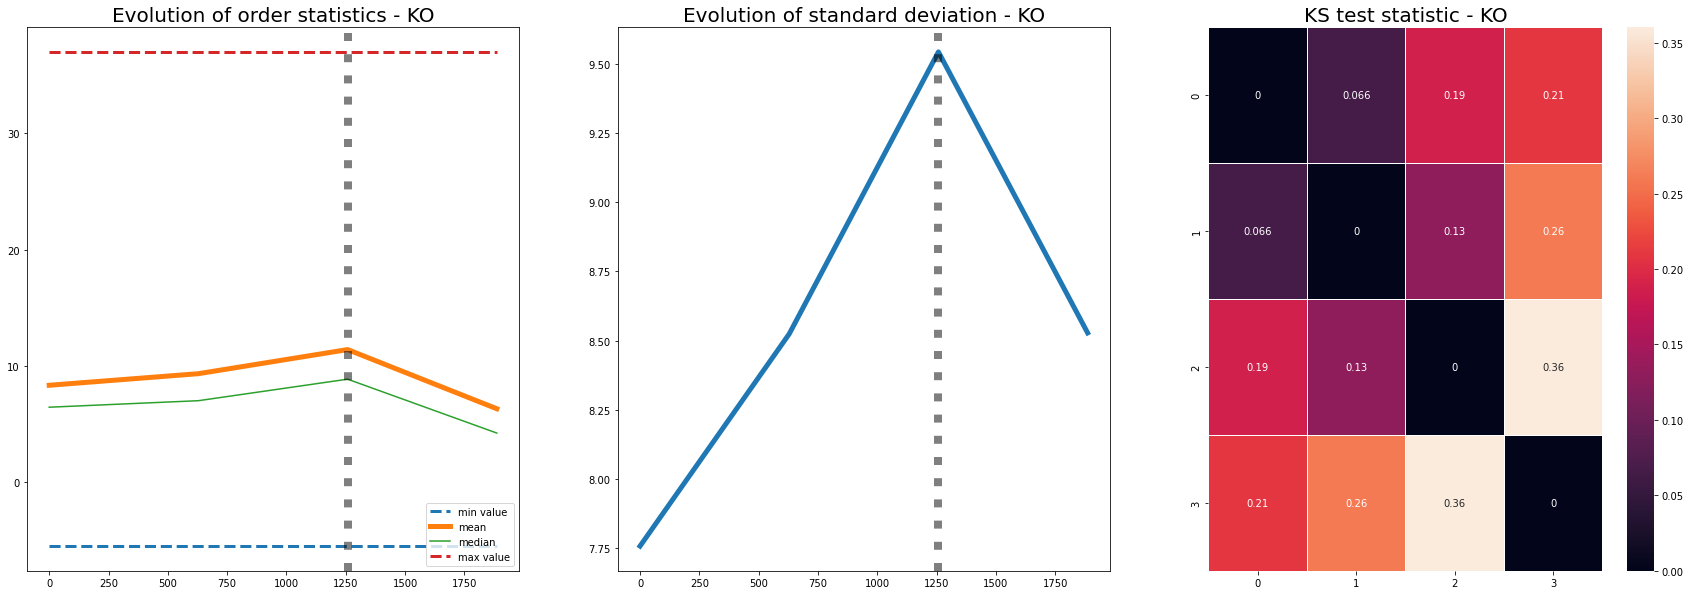

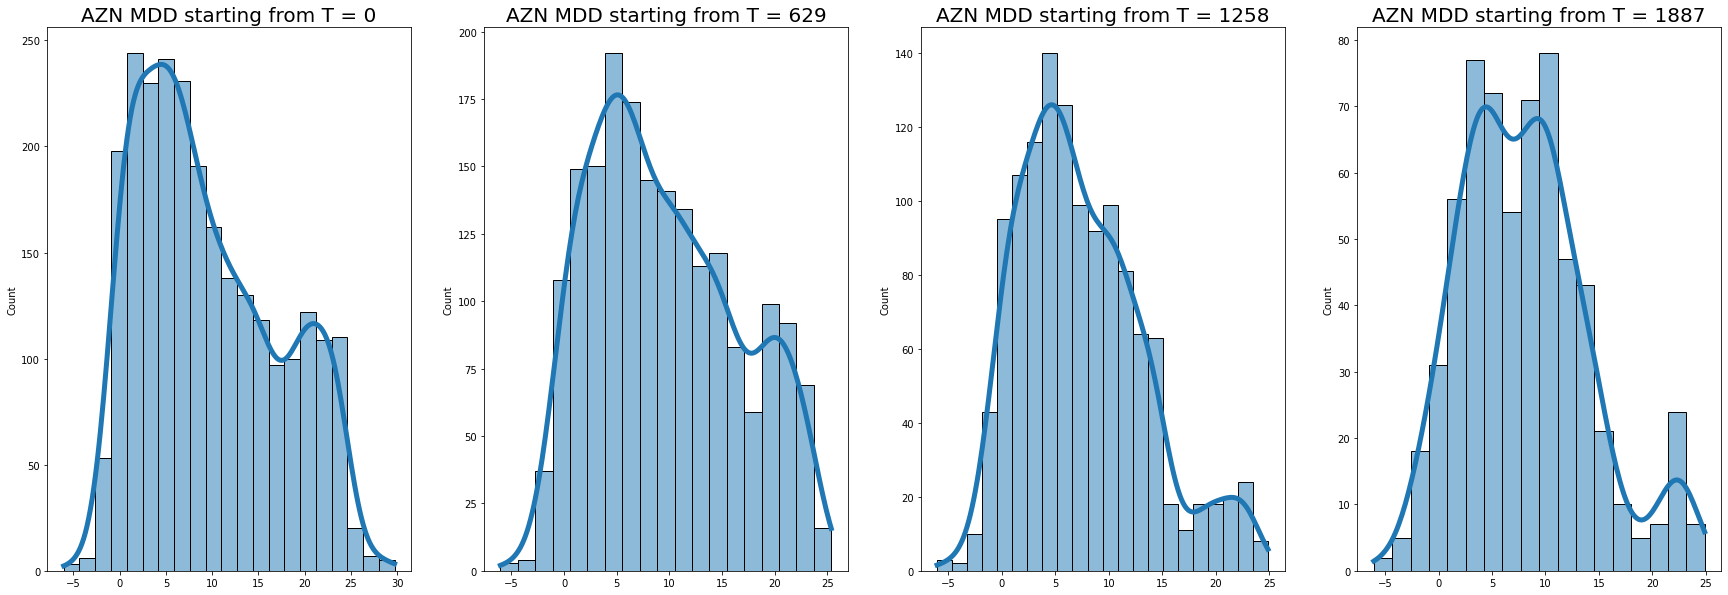

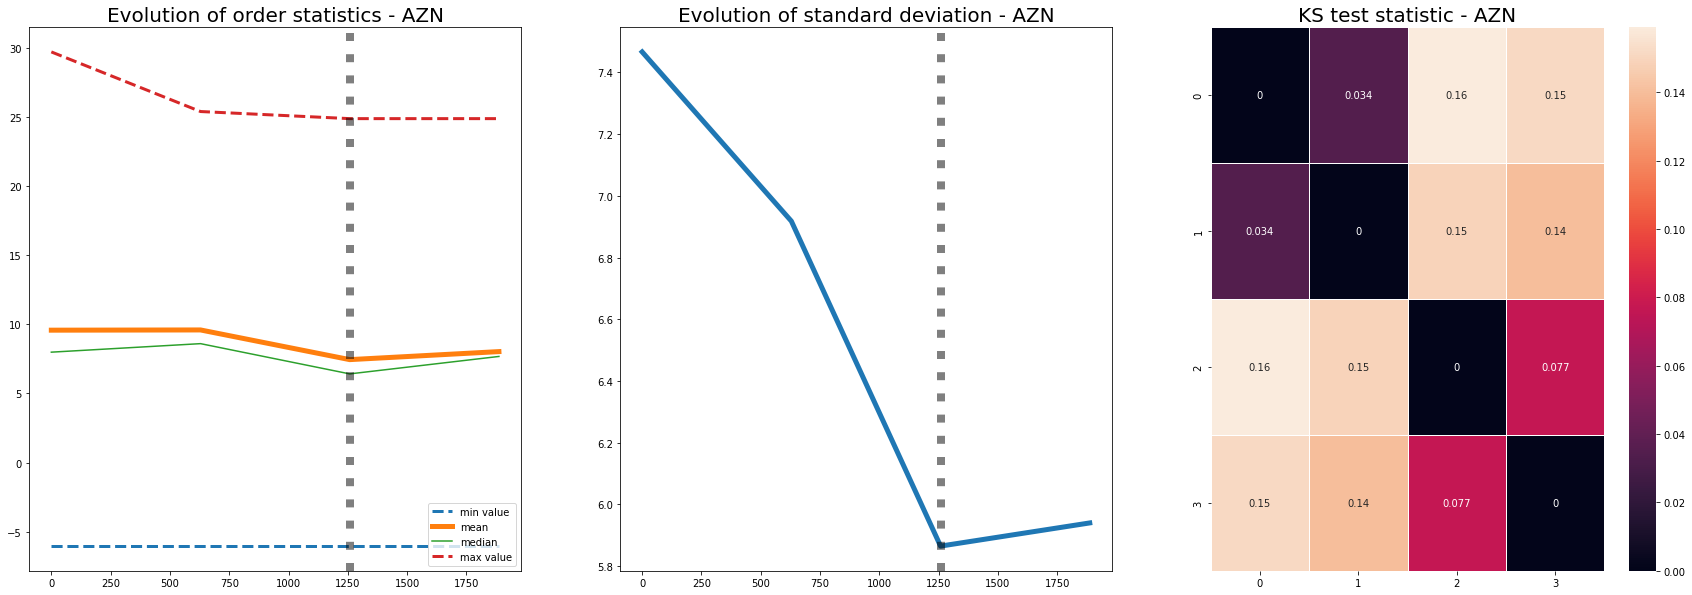

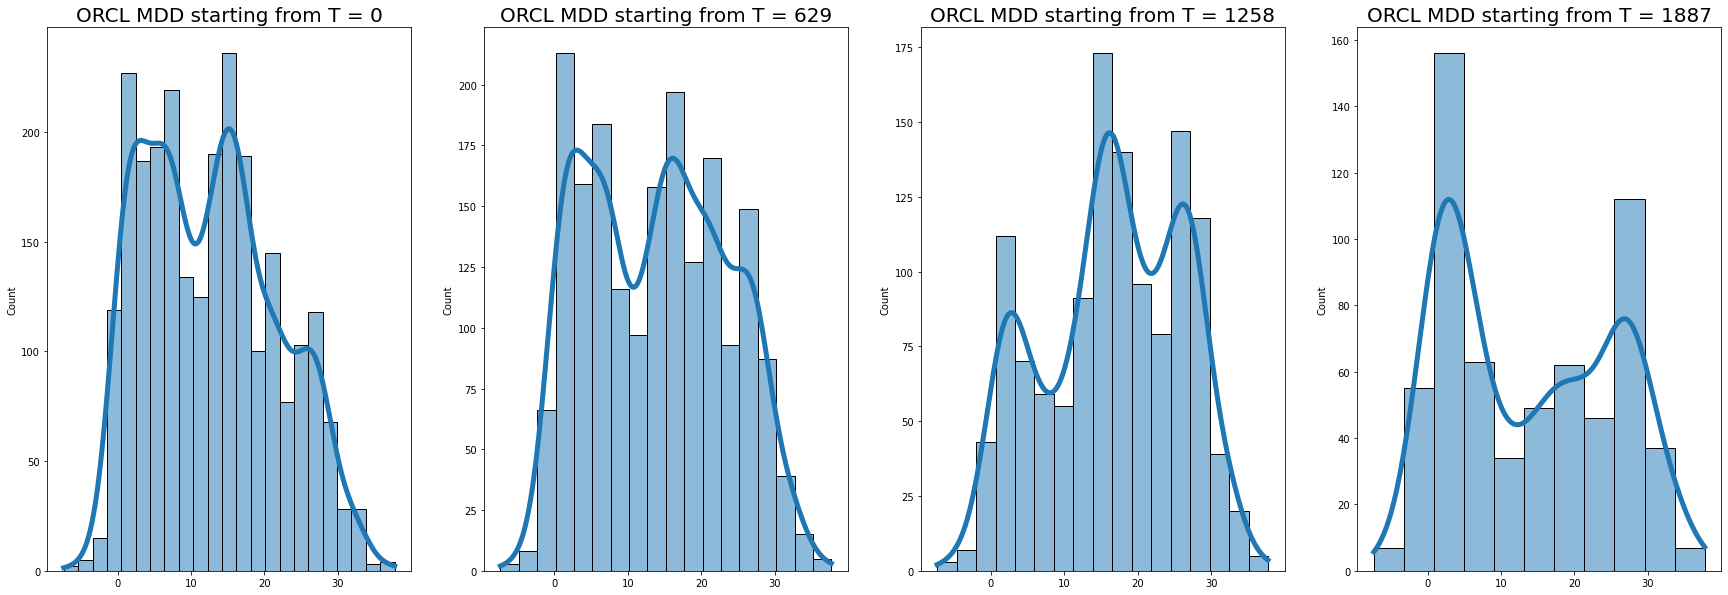

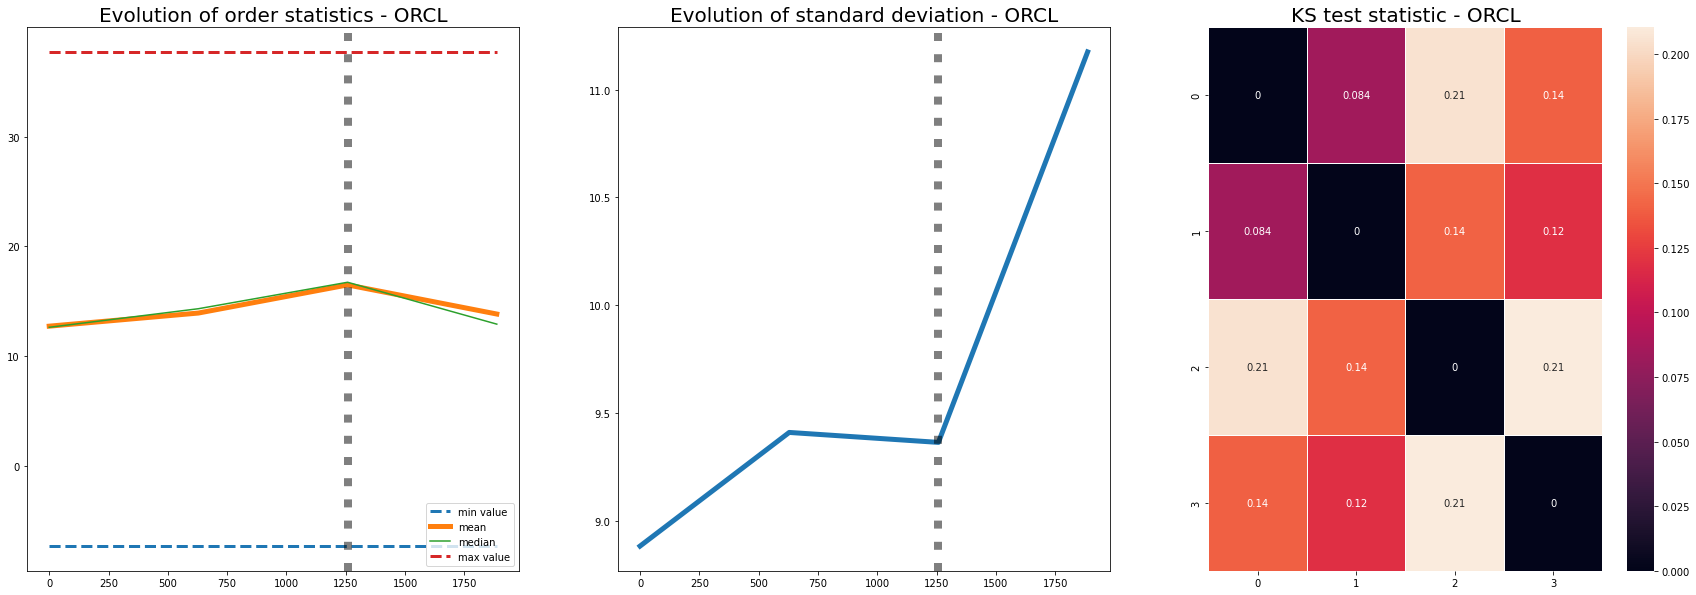

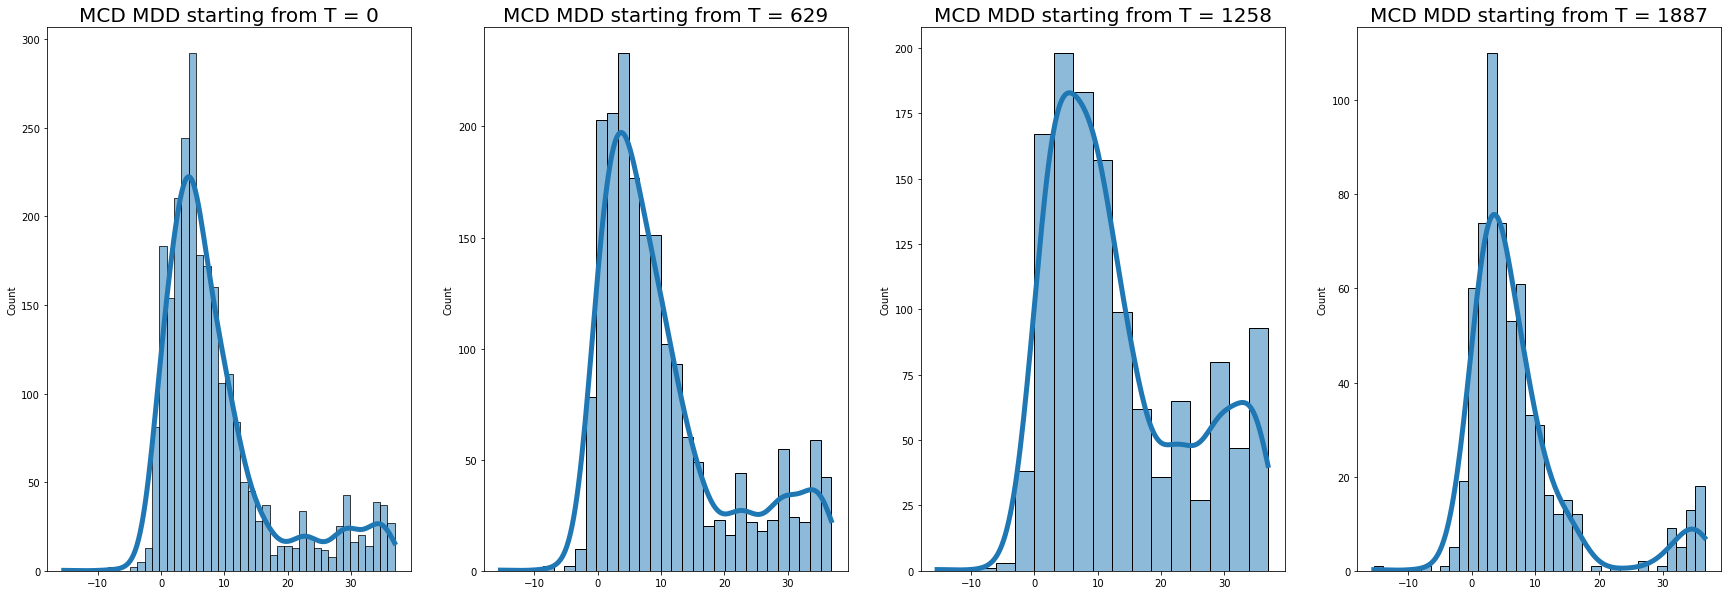

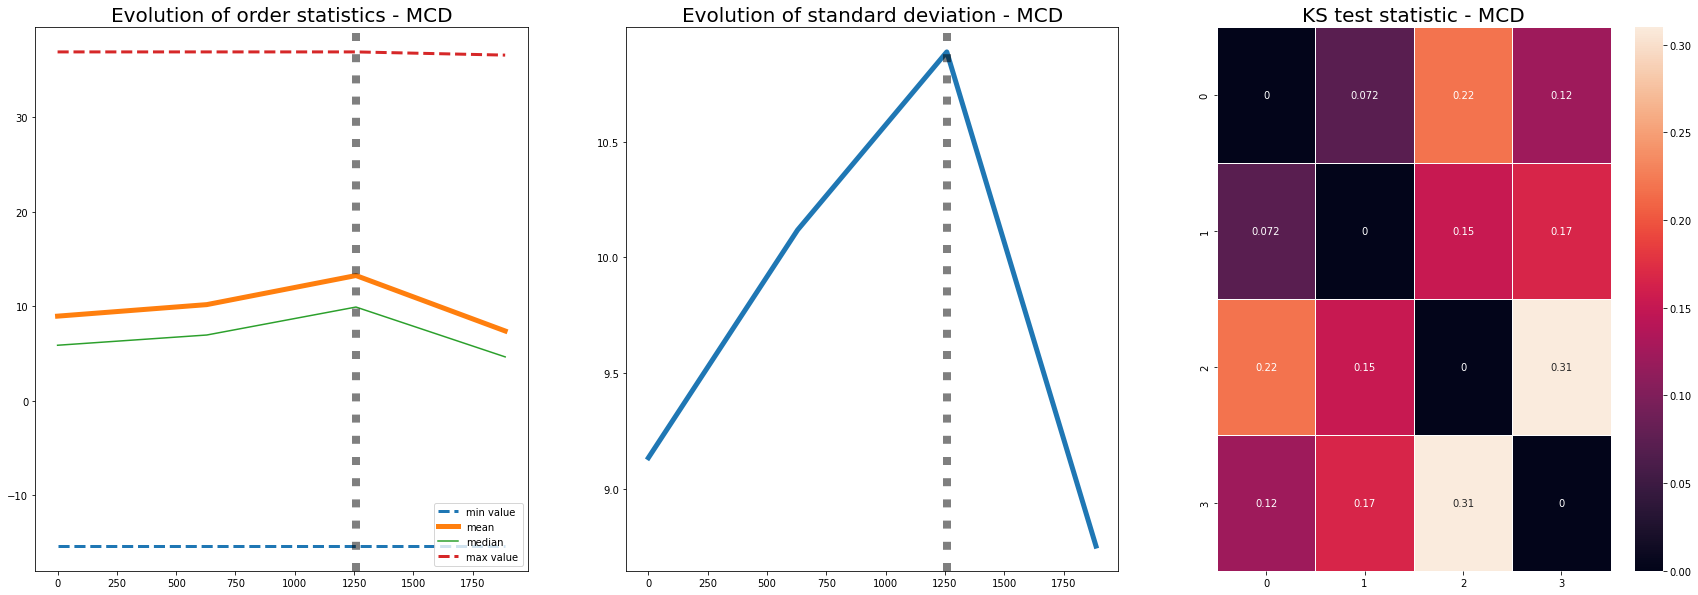

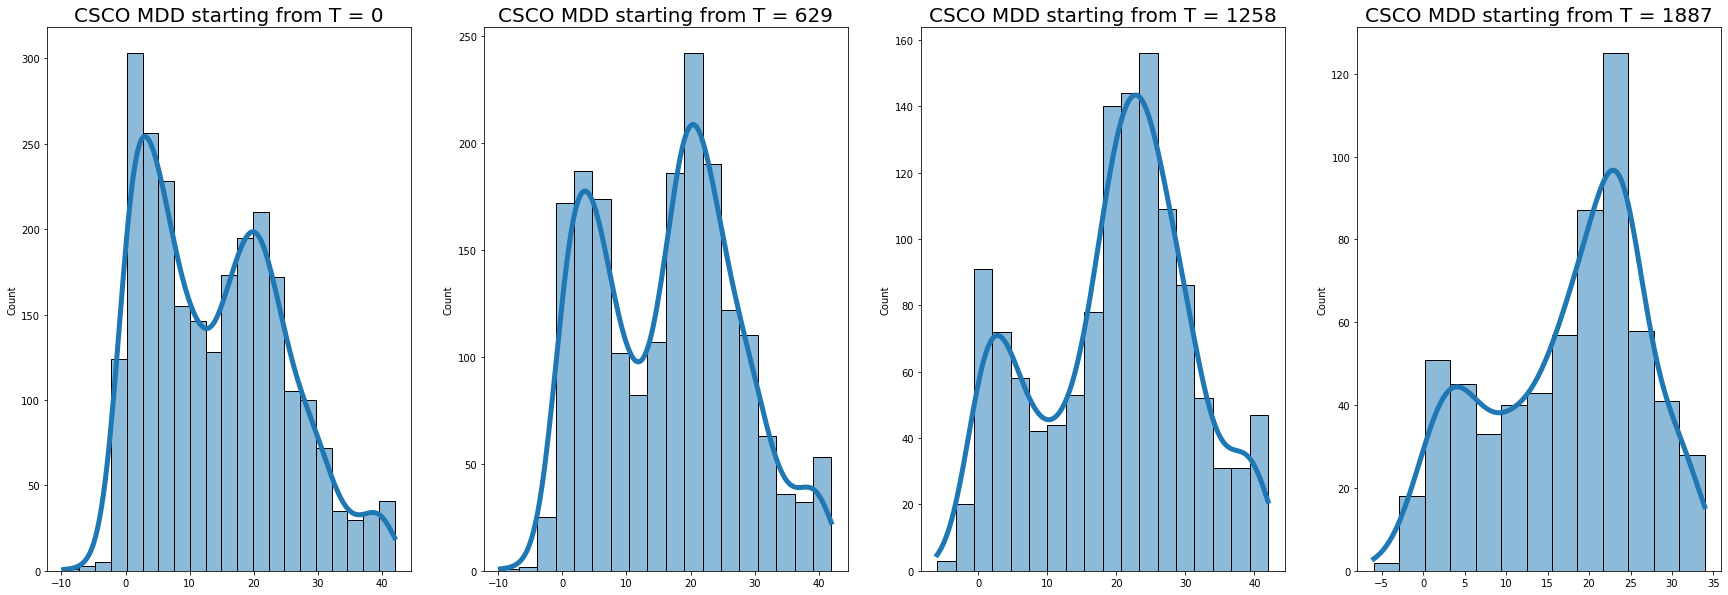

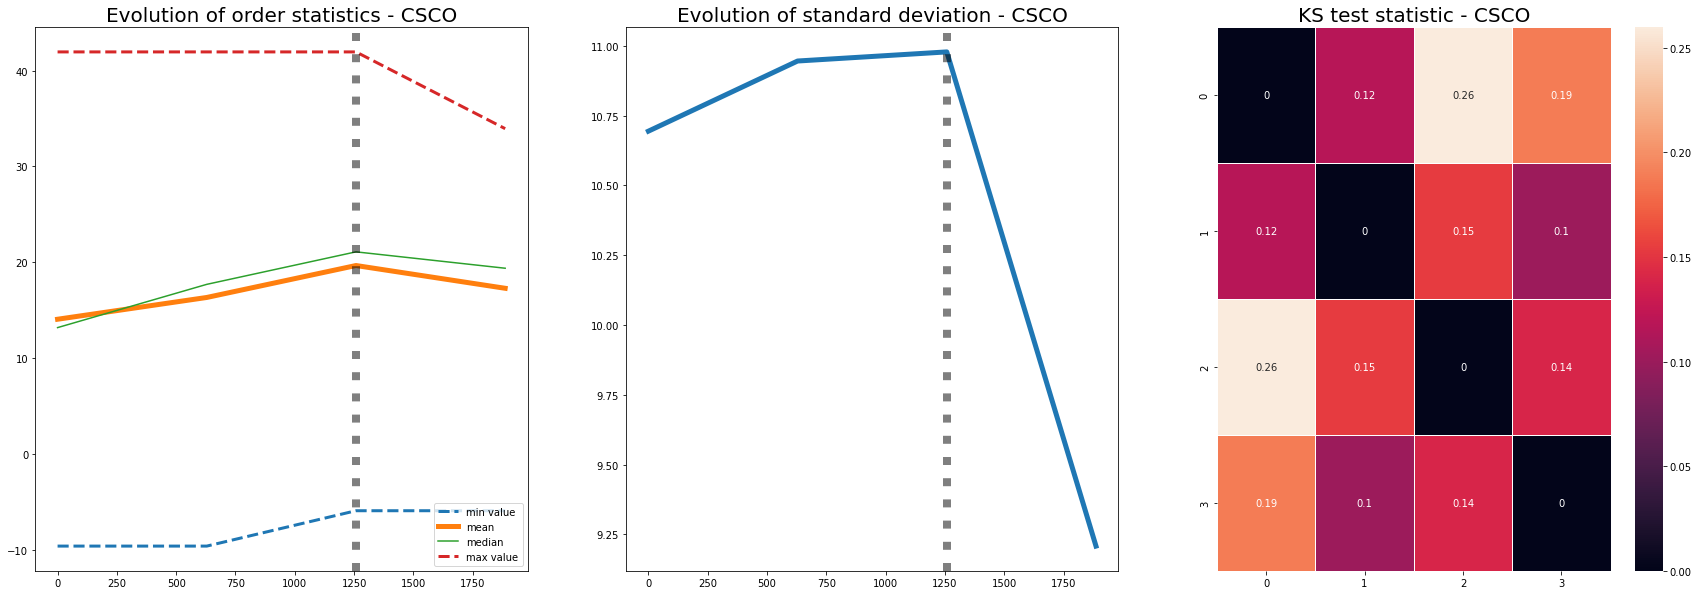

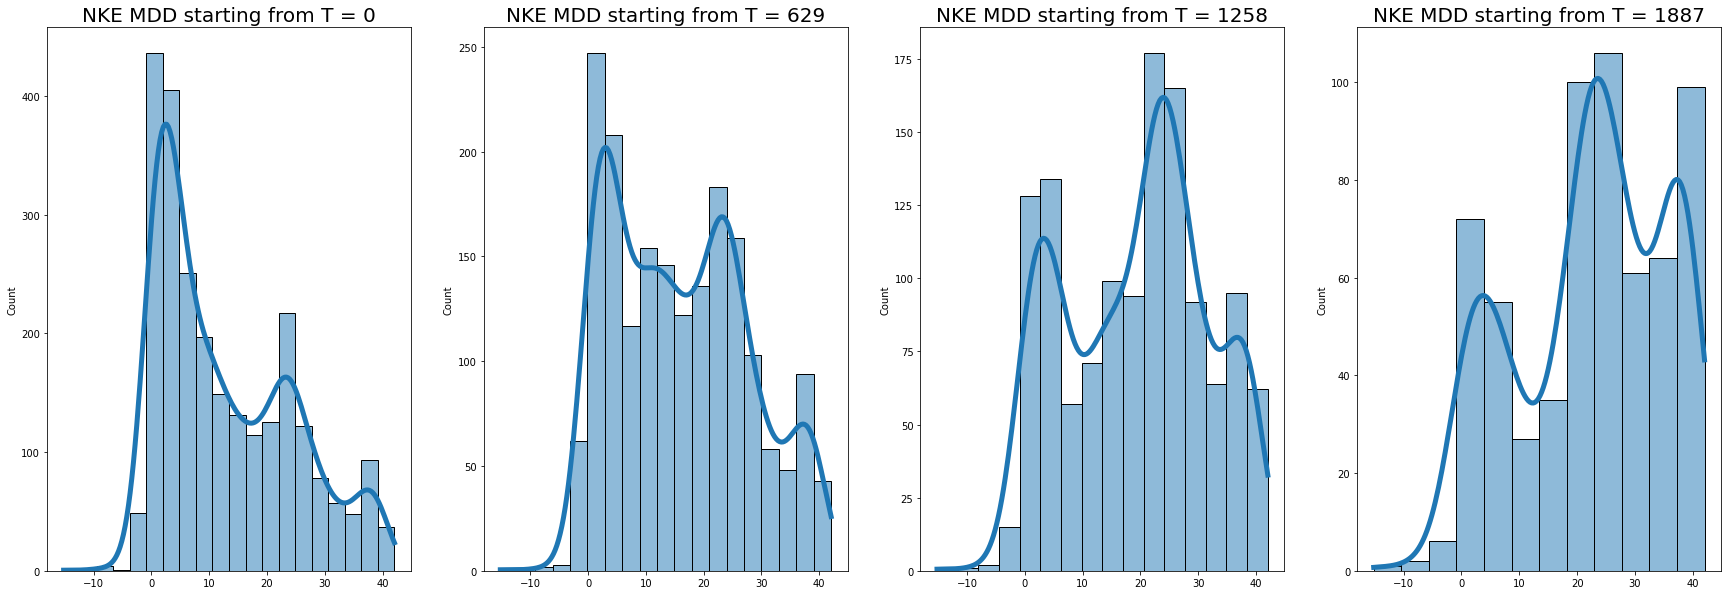

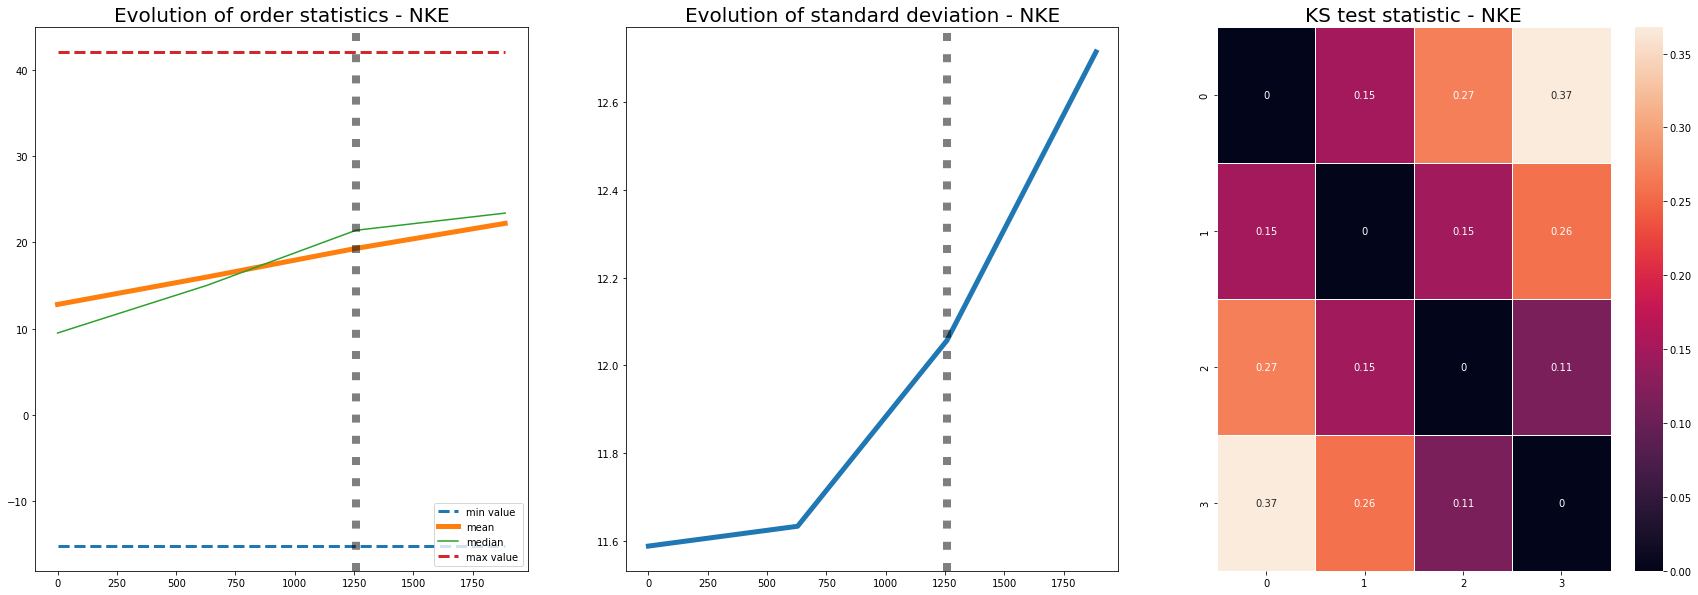

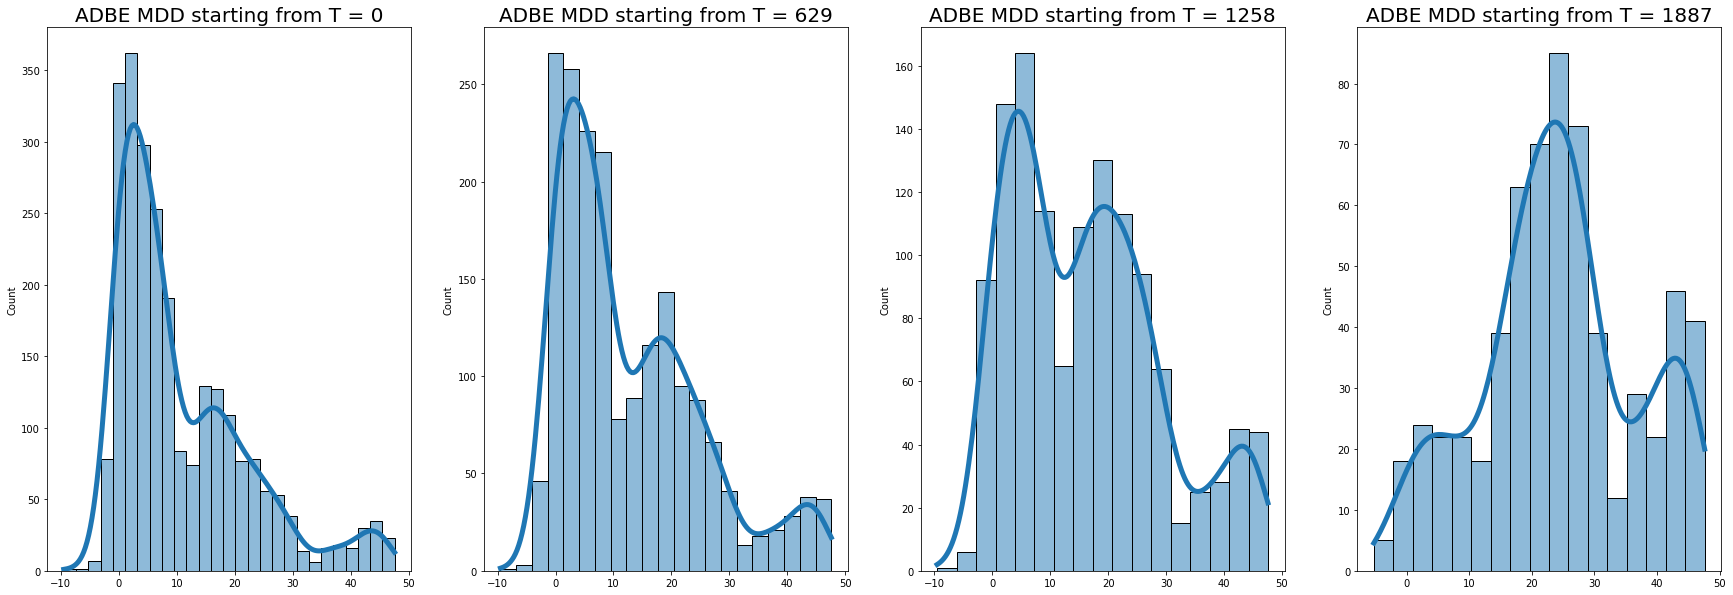

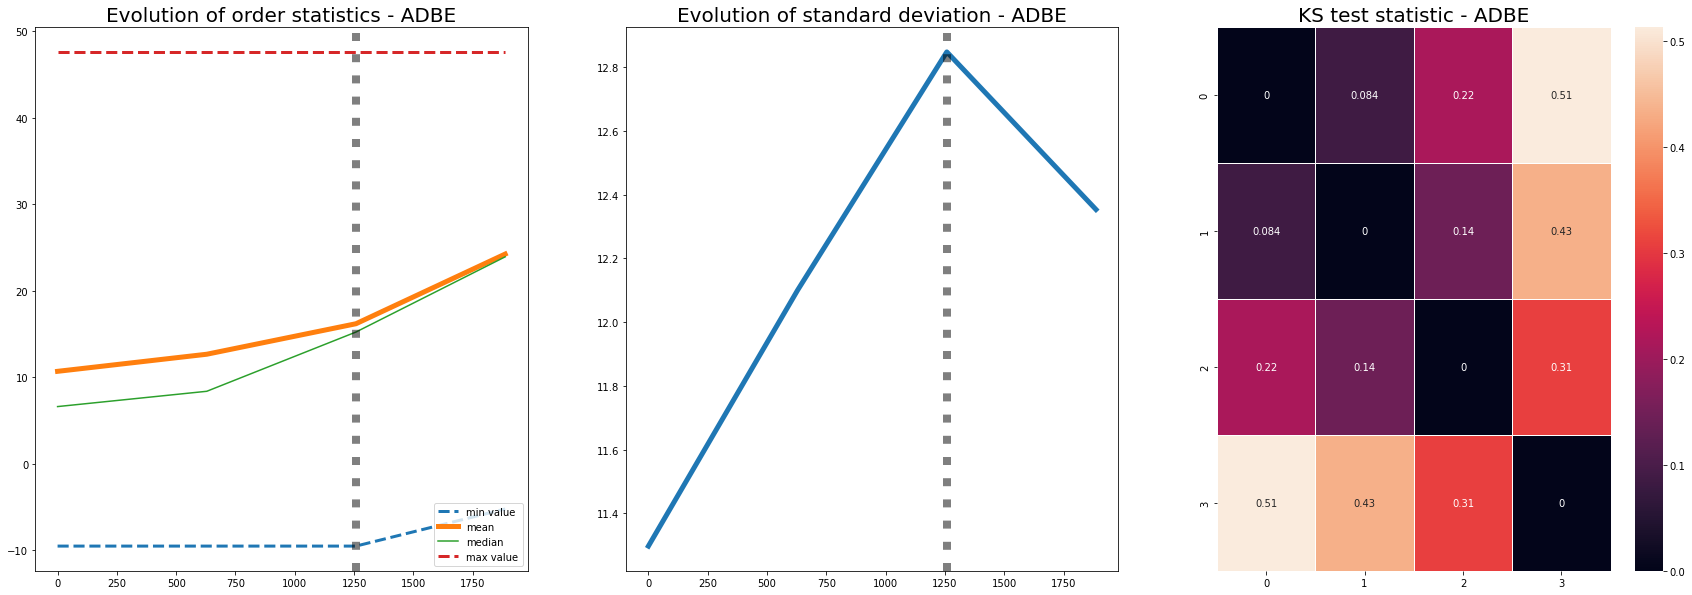

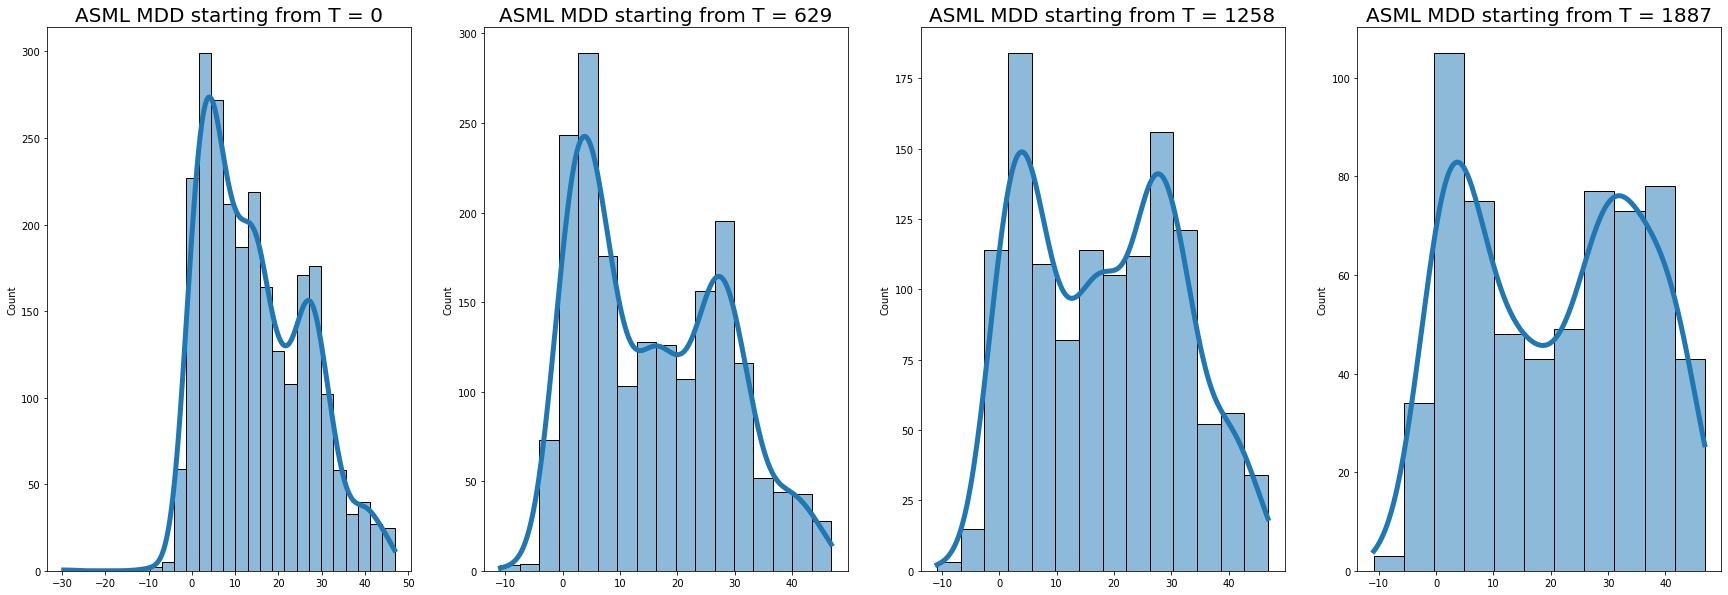

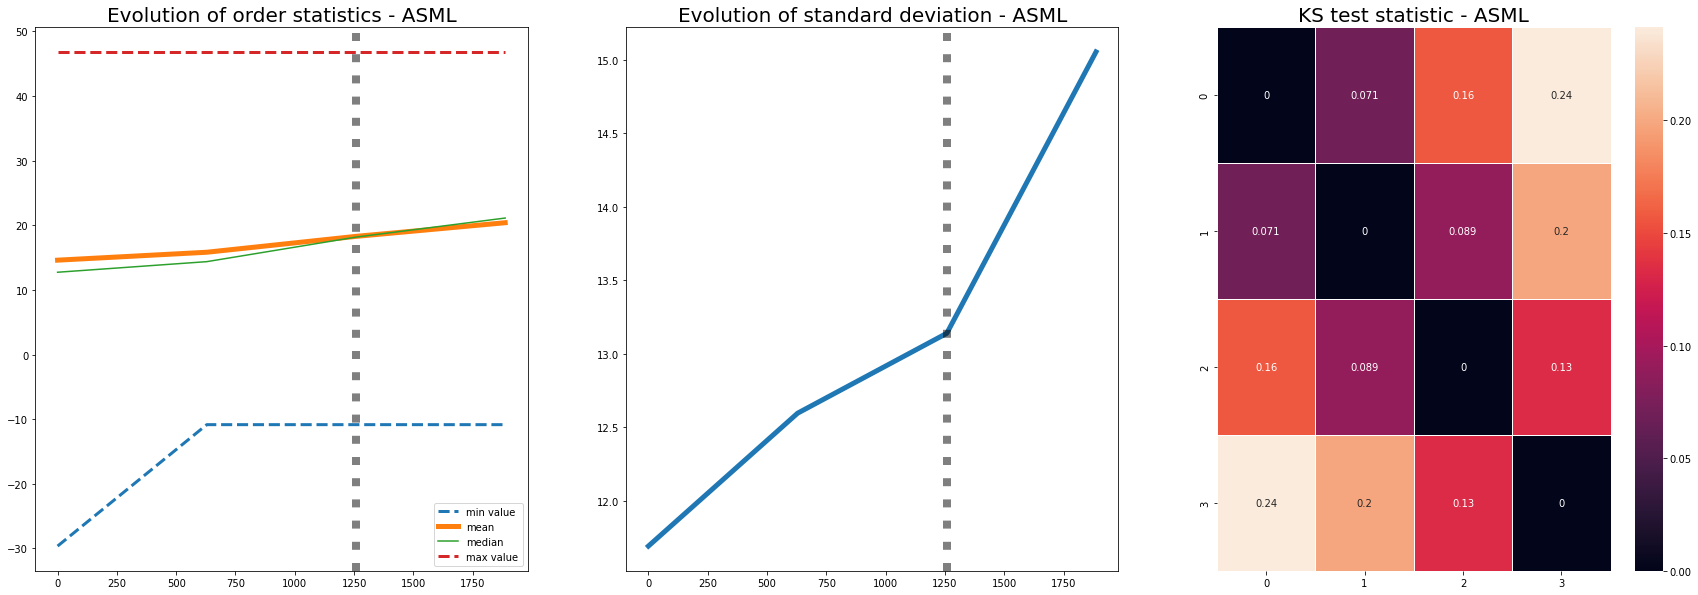

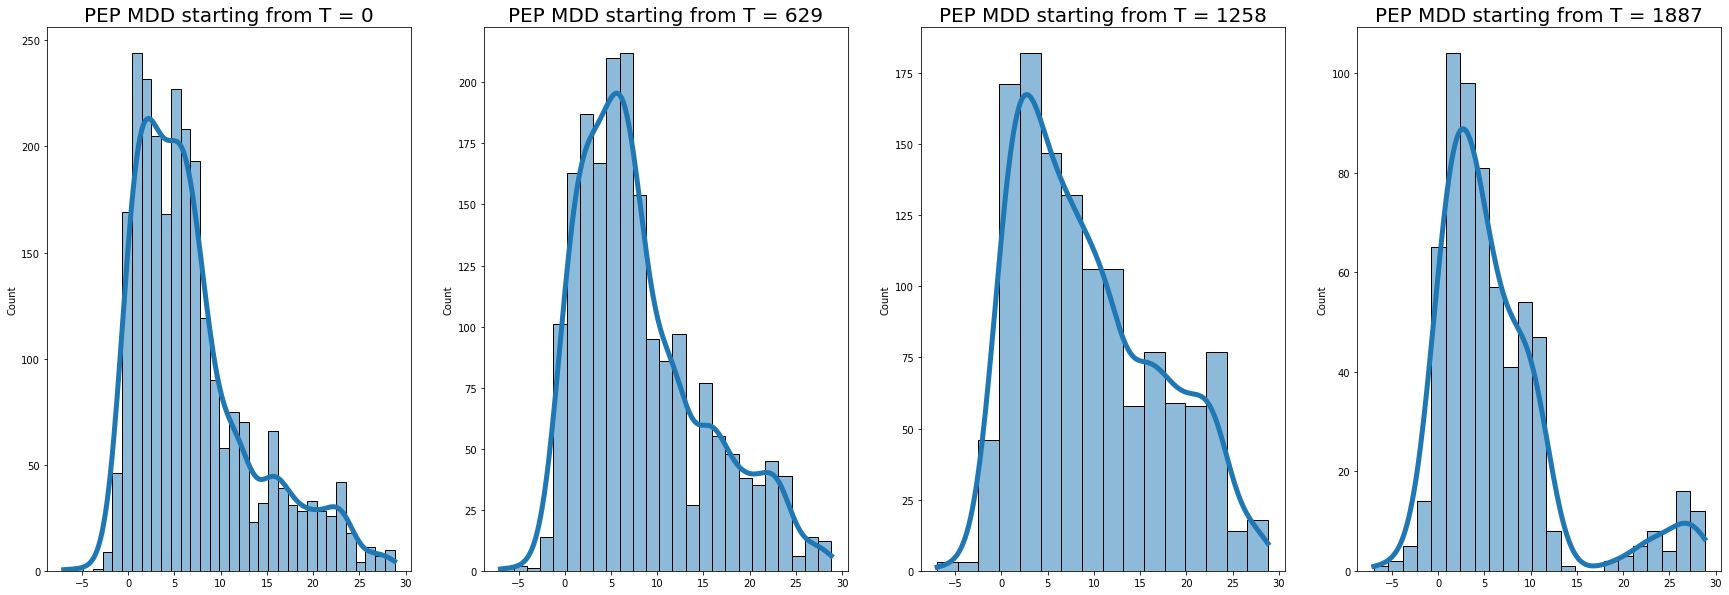

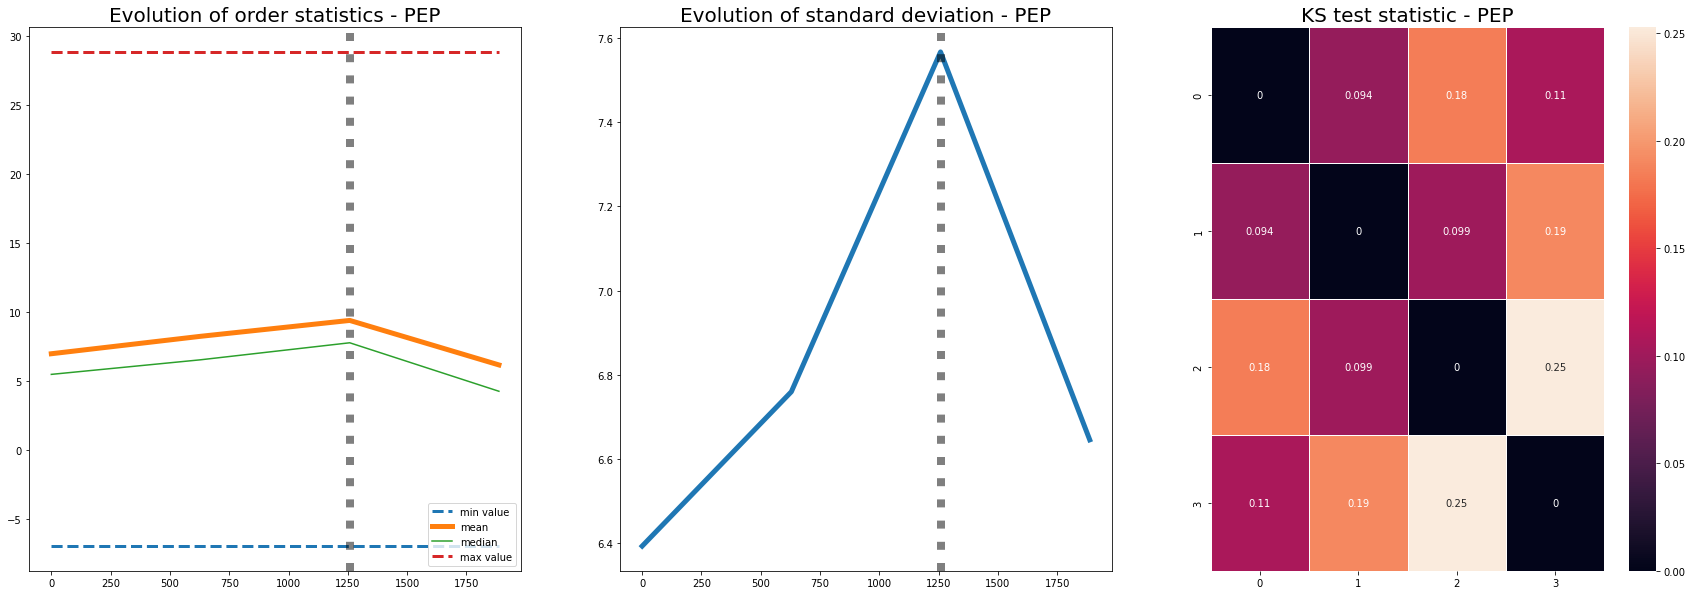

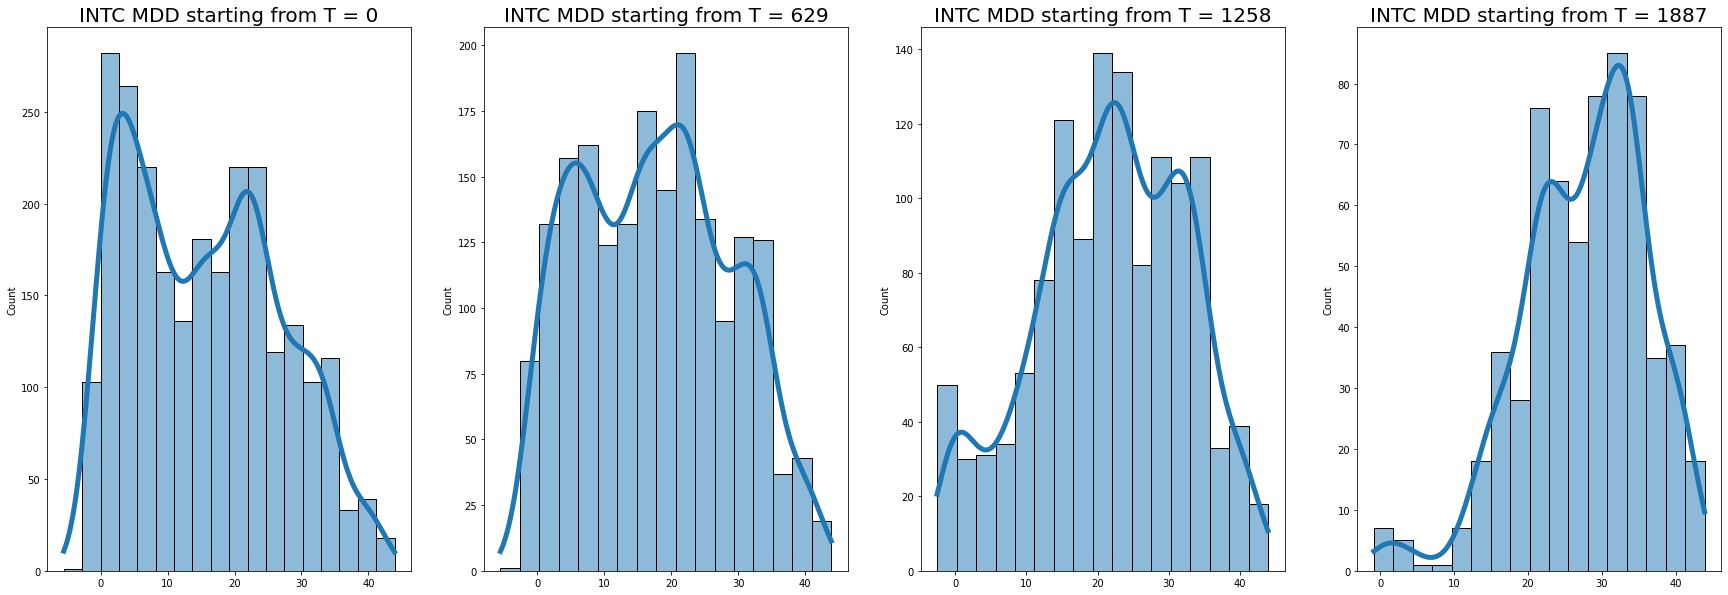

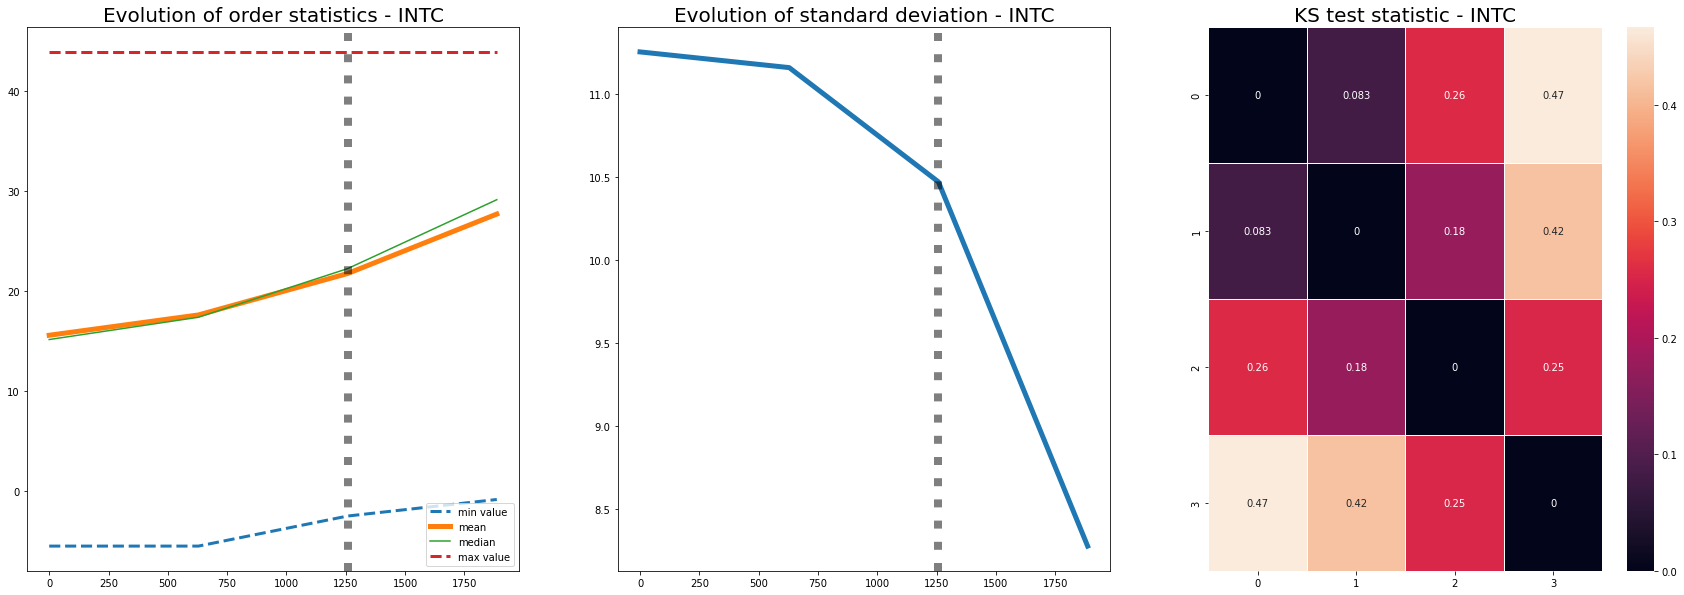

In [202]:
list_of_data = []
for ticker in list_of_tickers:
    data = yf.Ticker(ticker).history(interval = "1d", period = "10y").Close.values
    steps_1d = CreateSteps(data, 4)
    list_of_values_1d = plotMaxDrawdown(data, steps_1d, name=ticker)
    minimal = [np.min(list_of_values_1d[i]) for i in range(len(steps_1d))]
    maximal = [np.max(list_of_values_1d[i]) for i in range(len(steps_1d))]
    mean = [np.mean(list_of_values_1d[i]) for i in range(len(steps_1d))]
    median = [np.median(list_of_values_1d[i]) for i in range(len(steps_1d))]
    std = [np.std(list_of_values_1d[i]) for i in range(len(steps_1d))]

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10));

    ax1.plot(steps_1d, minimal, '--', label = "min value", lw=3);
    ax1.plot(steps_1d, mean, label = "mean", lw=5);
    ax1.plot(steps_1d, median, label = "median");
    ax1.plot(steps_1d, maximal, '--', label = "max value", lw=3);
    ax1.axvline(steps_1d[int(3*len(steps_1d)/4)-1],linestyle=':', lw=8, color="black", alpha = 0.5);
    ax1.legend(loc="lower right");
    ax1.set_title("Evolution of order statistics - " + ticker, fontsize=20);
    
    ax2.plot(steps_1d, std, label = "standard deviation", lw=5);
    ax2.axvline(steps_1d[int(3*len(steps_1d)/4)-1],linestyle=':', lw=8, color="black", alpha = 0.5);
    ax2.set_title("Evolution of standard deviation - " + ticker, fontsize=20);

    matrix_pvalues = np.array([  [ ks(list_of_values_1d[i], list_of_values_1d[j])[0] for i in range(len(steps_1d))] for j in range(len(steps_1d))]);
    sns.heatmap(matrix_pvalues, linewidth=0.5, annot=True);
    ax3.set_title('KS test statistic - ' + ticker, fontsize=20);


En comparant ces différents actifs, certains voient leurs distributions suivre les mêmes comportements que celui du CAC40 alors que d'autres un peu moins (notamment en terme de l'évolution de la standard deviation). La bimodalité n'est pas non plus une règle universelle et on estime donc que ces analyses dépendent fortement de l'actif étudié.

## **FIN**